In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from fashion_mnist.utils.mnist_reader import load_mnist

In [3]:
total_train_image, total_train_labels = load_mnist('./fashion_mnist/data/fashion/', kind='train')
test_image, test_labels = load_mnist('./fashion_mnist/data/fashion/', kind='t10k')

In [4]:
train_image, validation_image = train_test_split(total_train_image, test_size=0.15, random_state=0)
train_labels, validation_labels = train_test_split(total_train_labels, test_size=0.15, random_state=0)

In [5]:
train_labels_onehot = pd.get_dummies(train_labels)
validation_labels_onehot = pd.get_dummies(validation_labels)
test_labels_onehot = pd.get_dummies(test_labels)

In [6]:
def softmax(z):
    exp_num = tf.exp(z)
    sum_div = tf.reduce_sum(exp_num,1, keepdims=True)
    return exp_num / sum_div

def cross_entropy(y, h):
    return tf.reduce_mean(tf.reduce_sum(-tf.log(h)*y,1, keepdims=True))

def relu(z):
    return tf.maximum(z, 0)
    
def relu_derivative(x):
    condition = tf.greater(x, 0.)
    return tf.where(condition,tf.ones_like(x),tf.zeros_like(x))

In [7]:
lr = 0.0000001
hidden = 2**8
batch = train_image.shape[0]
epochs = 10000
iterations = int(train_image.shape[0]/batch)

In [8]:
#plt.imshow(test_image[30].reshape(28,28))

In [9]:
x_ori = tf.placeholder(tf.float32, shape =([None,28*28]))
X = tf.concat([tf.ones((tf.shape(x_ori)[0],1),dtype=tf.float32),x_ori],axis=1)

y = tf.placeholder(tf.float32, shape =([None, 10]))

In [10]:
theta1 = tf.get_variable("theta1", shape=(28*28+1,hidden), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [11]:
gradient1 = tf.get_variable("gradient1", shape=(28*28+1,hidden), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [12]:
theta2 = tf.get_variable("theta2", shape=(hidden+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [13]:
gradient2 = tf.get_variable("gradient2", shape=(hidden+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [14]:
z1 = tf.matmul(X, theta1)
h1_ori = relu(z1)
h1 = tf.concat([tf.ones((tf.shape(x_ori)[0],1),dtype=tf.float32),h1_ori],axis=1)

In [15]:
z2 = tf.matmul(h1, theta2)
h2 = softmax(z2)

In [16]:
gradient2_update = gradient2.assign(tf.tensordot(tf.transpose(h1), tf.subtract(h2, y),1))

In [17]:
theta2_update = theta2.assign(theta2 - lr * gradient2)

In [18]:
dE_dz2 = h2-y

In [19]:
dh1_dz = relu_derivative(z1)

In [20]:
dE_dh1 = tf.matmul(dE_dz2 , tf.transpose(theta2[1:,:]))

In [21]:
dE_dz1 = tf.multiply(dE_dh1,dh1_dz)

In [22]:
gradient1_update = gradient1.assign(tf.matmul(tf.transpose(X), dE_dz1))

In [23]:
theta1_update = theta1.assign(theta1 - lr * gradient1)

In [24]:
loss = cross_entropy(y,h2)

In [25]:
tf_X = tf.placeholder(tf.float32)
tf_X_norm = tf.image.per_image_standardization(tf_X)

In [26]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

train_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: train_image})
validation_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: validation_image})
test_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: test_image})

In [27]:
sess.run(tf.global_variables_initializer())

train_epoch_loss_list = []
validation_epoch_loss_list = []

for i in range(epochs):
    batch_accumulate_loss = 0
    
    print('Epoch {}'.format(i))
    for j in range(iterations):
        index = j*batch
        theta_value = sess.run([gradient2_update,theta2_update,gradient1_update, theta1_update], feed_dict={x_ori:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})
        train_loss_value = sess.run(loss, feed_dict={x_ori:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})
        batch_accumulate_loss += train_loss_value

    train_epoch_loss = batch_accumulate_loss/iterations
    train_epoch_loss_list.append(train_epoch_loss)
    validation_epoch_loss = sess.run(loss, feed_dict={x_ori:validation_image_norm, y:validation_labels_onehot})
    validation_epoch_loss_list.append(validation_epoch_loss)

    print('Training loss:')
    print(train_epoch_loss)
    print('Validation loss:')
    print(validation_epoch_loss)

Epoch 0
Iteration loss:
2.87434983253479
Validation loss:
2.8740926
Epoch 1
Iteration loss:
2.6798174381256104
Validation loss:
2.6784117
Epoch 2
Iteration loss:
2.5215296745300293
Validation loss:
2.51924
Epoch 3
Iteration loss:
2.3889122009277344
Validation loss:
2.3859067
Epoch 4
Iteration loss:
2.2758309841156006
Validation loss:
2.2722144
Epoch 5
Iteration loss:
2.1782026290893555
Validation loss:
2.1740491
Epoch 6
Iteration loss:
2.092947244644165
Validation loss:
2.0883331
Epoch 7
Iteration loss:
2.017646551132202
Validation loss:
2.012596
Epoch 8
Iteration loss:
1.950357437133789
Validation loss:
1.9449396
Epoch 9
Iteration loss:
1.8896129131317139
Validation loss:
1.8838816
Epoch 10
Iteration loss:
1.8343188762664795
Validation loss:
1.828304
Epoch 11
Iteration loss:
1.7836655378341675
Validation loss:
1.777408
Epoch 12
Iteration loss:
1.737012267112732
Validation loss:
1.7305505
Epoch 13
Iteration loss:
1.6938802003860474
Validation loss:
1.6872398
Epoch 14
Iteration loss:
1.

Iteration loss:
0.8258682489395142
Validation loss:
0.81852746
Epoch 119
Iteration loss:
0.823978841304779
Validation loss:
0.8166271
Epoch 120
Iteration loss:
0.8221124410629272
Validation loss:
0.8147499
Epoch 121
Iteration loss:
0.8202679753303528
Validation loss:
0.8128949
Epoch 122
Iteration loss:
0.8184454441070557
Validation loss:
0.8110616
Epoch 123
Iteration loss:
0.8166442513465881
Validation loss:
0.8092498
Epoch 124
Iteration loss:
0.8148642778396606
Validation loss:
0.80745876
Epoch 125
Iteration loss:
0.8131051659584045
Validation loss:
0.8056884
Epoch 126
Iteration loss:
0.8113662600517273
Validation loss:
0.8039385
Epoch 127
Iteration loss:
0.8096475005149841
Validation loss:
0.80220854
Epoch 128
Iteration loss:
0.8079487085342407
Validation loss:
0.80049837
Epoch 129
Iteration loss:
0.8062689900398254
Validation loss:
0.79880786
Epoch 130
Iteration loss:
0.8046073913574219
Validation loss:
0.79713583
Epoch 131
Iteration loss:
0.8029639720916748
Validation loss:
0.79548

Iteration loss:
0.6942830681800842
Validation loss:
0.68584615
Epoch 233
Iteration loss:
0.6935551762580872
Validation loss:
0.68511146
Epoch 234
Iteration loss:
0.6928313374519348
Validation loss:
0.6843808
Epoch 235
Iteration loss:
0.6921119689941406
Validation loss:
0.6836545
Epoch 236
Iteration loss:
0.6913964748382568
Validation loss:
0.6829323
Epoch 237
Iteration loss:
0.690684974193573
Validation loss:
0.68221444
Epoch 238
Iteration loss:
0.689977765083313
Validation loss:
0.6815007
Epoch 239
Iteration loss:
0.6892746686935425
Validation loss:
0.68079126
Epoch 240
Iteration loss:
0.6885754466056824
Validation loss:
0.6800857
Epoch 241
Iteration loss:
0.6878800392150879
Validation loss:
0.6793841
Epoch 242
Iteration loss:
0.6871885657310486
Validation loss:
0.67868644
Epoch 243
Iteration loss:
0.6865010857582092
Validation loss:
0.6779928
Epoch 244
Iteration loss:
0.685817539691925
Validation loss:
0.6773031
Epoch 245
Iteration loss:
0.6851380467414856
Validation loss:
0.6766173


Iteration loss:
0.631338357925415
Validation loss:
0.6224735
Epoch 347
Iteration loss:
0.6309170722961426
Validation loss:
0.62205094
Epoch 348
Iteration loss:
0.6304974555969238
Validation loss:
0.6216302
Epoch 349
Iteration loss:
0.6300796866416931
Validation loss:
0.6212112
Epoch 350
Iteration loss:
0.6296637058258057
Validation loss:
0.6207937
Epoch 351
Iteration loss:
0.6292492151260376
Validation loss:
0.62037814
Epoch 352
Iteration loss:
0.628836452960968
Validation loss:
0.61996406
Epoch 353
Iteration loss:
0.6284251809120178
Validation loss:
0.61955166
Epoch 354
Iteration loss:
0.6280155181884766
Validation loss:
0.61914074
Epoch 355
Iteration loss:
0.6276074051856995
Validation loss:
0.6187313
Epoch 356
Iteration loss:
0.6272008419036865
Validation loss:
0.61832356
Epoch 357
Iteration loss:
0.6267958879470825
Validation loss:
0.61791754
Epoch 358
Iteration loss:
0.6263924837112427
Validation loss:
0.61751294
Epoch 359
Iteration loss:
0.6259905099868774
Validation loss:
0.6171

Iteration loss:
0.591915488243103
Validation loss:
0.5830187
Epoch 461
Iteration loss:
0.5916306376457214
Validation loss:
0.5827348
Epoch 462
Iteration loss:
0.5913465619087219
Validation loss:
0.5824518
Epoch 463
Iteration loss:
0.5910634994506836
Validation loss:
0.58216965
Epoch 464
Iteration loss:
0.5907811522483826
Validation loss:
0.5818883
Epoch 465
Iteration loss:
0.5904996991157532
Validation loss:
0.5816079
Epoch 466
Iteration loss:
0.5902189612388611
Validation loss:
0.58132815
Epoch 467
Iteration loss:
0.5899391174316406
Validation loss:
0.5810494
Epoch 468
Iteration loss:
0.589660108089447
Validation loss:
0.58077157
Epoch 469
Iteration loss:
0.589381992816925
Validation loss:
0.5804946
Epoch 470
Iteration loss:
0.5891046524047852
Validation loss:
0.5802185
Epoch 471
Iteration loss:
0.5888280272483826
Validation loss:
0.57994324
Epoch 472
Iteration loss:
0.5885522365570068
Validation loss:
0.57966876
Epoch 473
Iteration loss:
0.5882771611213684
Validation loss:
0.57939506

Iteration loss:
0.5640577673912048
Validation loss:
0.55540544
Epoch 575
Iteration loss:
0.5638481378555298
Validation loss:
0.55519897
Epoch 576
Iteration loss:
0.5636389851570129
Validation loss:
0.554993
Epoch 577
Iteration loss:
0.5634303092956543
Validation loss:
0.55478746
Epoch 578
Iteration loss:
0.5632221102714539
Validation loss:
0.5545825
Epoch 579
Iteration loss:
0.5630145072937012
Validation loss:
0.5543781
Epoch 580
Iteration loss:
0.5628074407577515
Validation loss:
0.55417424
Epoch 581
Iteration loss:
0.56260085105896
Validation loss:
0.55397093
Epoch 582
Iteration loss:
0.5623947381973267
Validation loss:
0.5537682
Epoch 583
Iteration loss:
0.562188982963562
Validation loss:
0.553566
Epoch 584
Iteration loss:
0.5619837641716003
Validation loss:
0.5533643
Epoch 585
Iteration loss:
0.5617790818214417
Validation loss:
0.553163
Epoch 586
Iteration loss:
0.5615748167037964
Validation loss:
0.55296224
Epoch 587
Iteration loss:
0.5613710284233093
Validation loss:
0.55276185
E

Iteration loss:
0.5429532527923584
Validation loss:
0.53469855
Epoch 689
Iteration loss:
0.542789876461029
Validation loss:
0.5345388
Epoch 690
Iteration loss:
0.5426269173622131
Validation loss:
0.53437936
Epoch 691
Iteration loss:
0.5424641370773315
Validation loss:
0.5342202
Epoch 692
Iteration loss:
0.5423017740249634
Validation loss:
0.53406155
Epoch 693
Iteration loss:
0.5421397686004639
Validation loss:
0.5339032
Epoch 694
Iteration loss:
0.5419780015945435
Validation loss:
0.5337451
Epoch 695
Iteration loss:
0.5418164730072021
Validation loss:
0.5335874
Epoch 696
Iteration loss:
0.5416553020477295
Validation loss:
0.53343004
Epoch 697
Iteration loss:
0.5414943695068359
Validation loss:
0.5332729
Epoch 698
Iteration loss:
0.541333794593811
Validation loss:
0.533116
Epoch 699
Iteration loss:
0.5411734580993652
Validation loss:
0.53295946
Epoch 700
Iteration loss:
0.5410134792327881
Validation loss:
0.5328032
Epoch 701
Iteration loss:
0.5408537983894348
Validation loss:
0.5326473


Iteration loss:
0.5262022018432617
Validation loss:
0.5184148
Epoch 803
Iteration loss:
0.5260702967643738
Validation loss:
0.51828724
Epoch 804
Iteration loss:
0.5259385704994202
Validation loss:
0.5181598
Epoch 805
Iteration loss:
0.5258070826530457
Validation loss:
0.51803255
Epoch 806
Iteration loss:
0.5256757736206055
Validation loss:
0.5179055
Epoch 807
Iteration loss:
0.5255447030067444
Validation loss:
0.51777864
Epoch 808
Iteration loss:
0.5254139304161072
Validation loss:
0.51765203
Epoch 809
Iteration loss:
0.5252833366394043
Validation loss:
0.5175256
Epoch 810
Iteration loss:
0.5251529812812805
Validation loss:
0.5173994
Epoch 811
Iteration loss:
0.5250228047370911
Validation loss:
0.5172733
Epoch 812
Iteration loss:
0.5248928666114807
Validation loss:
0.5171475
Epoch 813
Iteration loss:
0.5247631072998047
Validation loss:
0.5170219
Epoch 814
Iteration loss:
0.5246335864067078
Validation loss:
0.5168965
Epoch 815
Iteration loss:
0.5245043039321899
Validation loss:
0.516771

Iteration loss:
0.5124548077583313
Validation loss:
0.5052124
Epoch 917
Iteration loss:
0.5123445987701416
Validation loss:
0.5051073
Epoch 918
Iteration loss:
0.5122345089912415
Validation loss:
0.50500226
Epoch 919
Iteration loss:
0.5121245980262756
Validation loss:
0.5048975
Epoch 920
Iteration loss:
0.5120148658752441
Validation loss:
0.50479275
Epoch 921
Iteration loss:
0.5119052529335022
Validation loss:
0.50468814
Epoch 922
Iteration loss:
0.5117958188056946
Validation loss:
0.5045837
Epoch 923
Iteration loss:
0.5116865634918213
Validation loss:
0.5044794
Epoch 924
Iteration loss:
0.5115774273872375
Validation loss:
0.5043753
Epoch 925
Iteration loss:
0.5114684700965881
Validation loss:
0.50427127
Epoch 926
Iteration loss:
0.511359691619873
Validation loss:
0.50416744
Epoch 927
Iteration loss:
0.5112509727478027
Validation loss:
0.5040638
Epoch 928
Iteration loss:
0.5111424922943115
Validation loss:
0.5039603
Epoch 929
Iteration loss:
0.5110340714454651
Validation loss:
0.503857

Iteration loss:
0.500834584236145
Validation loss:
0.49417627
Epoch 1031
Iteration loss:
0.5007405281066895
Validation loss:
0.49408725
Epoch 1032
Iteration loss:
0.5006465315818787
Validation loss:
0.49399838
Epoch 1033
Iteration loss:
0.5005525946617126
Validation loss:
0.4939095
Epoch 1034
Iteration loss:
0.5004588961601257
Validation loss:
0.49382085
Epoch 1035
Iteration loss:
0.5003651976585388
Validation loss:
0.49373227
Epoch 1036
Iteration loss:
0.500271737575531
Validation loss:
0.49364376
Epoch 1037
Iteration loss:
0.5001783967018127
Validation loss:
0.49355546
Epoch 1038
Iteration loss:
0.5000851154327393
Validation loss:
0.49346712
Epoch 1039
Iteration loss:
0.4999920427799225
Validation loss:
0.49337903
Epoch 1040
Iteration loss:
0.49989908933639526
Validation loss:
0.49329102
Epoch 1041
Iteration loss:
0.4998062252998352
Validation loss:
0.49320307
Epoch 1042
Iteration loss:
0.4997134506702423
Validation loss:
0.49311528
Epoch 1043
Iteration loss:
0.49962079524993896
Vali

Iteration loss:
0.49108555912971497
Validation loss:
0.48496407
Epoch 1142
Iteration loss:
0.49100351333618164
Validation loss:
0.48488683
Epoch 1143
Iteration loss:
0.49092164635658264
Validation loss:
0.48480967
Epoch 1144
Iteration loss:
0.4908398389816284
Validation loss:
0.48473263
Epoch 1145
Iteration loss:
0.49075812101364136
Validation loss:
0.48465565
Epoch 1146
Iteration loss:
0.4906764626502991
Validation loss:
0.4845788
Epoch 1147
Iteration loss:
0.49059489369392395
Validation loss:
0.48450205
Epoch 1148
Iteration loss:
0.490513414144516
Validation loss:
0.48442534
Epoch 1149
Iteration loss:
0.4904319941997528
Validation loss:
0.48434886
Epoch 1150
Iteration loss:
0.4903506934642792
Validation loss:
0.48427236
Epoch 1151
Iteration loss:
0.4902694523334503
Validation loss:
0.48419592
Epoch 1152
Iteration loss:
0.4901883006095886
Validation loss:
0.48411956
Epoch 1153
Iteration loss:
0.4901072680950165
Validation loss:
0.4840433
Epoch 1154
Iteration loss:
0.4900263547897339
V

Iteration loss:
0.48252007365226746
Validation loss:
0.47695377
Epoch 1253
Iteration loss:
0.48244744539260864
Validation loss:
0.4768865
Epoch 1254
Iteration loss:
0.48237499594688416
Validation loss:
0.47681922
Epoch 1255
Iteration loss:
0.48230260610580444
Validation loss:
0.47675216
Epoch 1256
Iteration loss:
0.4822302460670471
Validation loss:
0.4766851
Epoch 1257
Iteration loss:
0.48215800523757935
Validation loss:
0.47661817
Epoch 1258
Iteration loss:
0.48208585381507874
Validation loss:
0.47655132
Epoch 1259
Iteration loss:
0.4820137619972229
Validation loss:
0.4764846
Epoch 1260
Iteration loss:
0.48194175958633423
Validation loss:
0.47641793
Epoch 1261
Iteration loss:
0.48186978697776794
Validation loss:
0.4763513
Epoch 1262
Iteration loss:
0.4817979335784912
Validation loss:
0.47628483
Epoch 1263
Iteration loss:
0.4817262589931488
Validation loss:
0.47621843
Epoch 1264
Iteration loss:
0.481654554605484
Validation loss:
0.47615203
Epoch 1265
Iteration loss:
0.4815829396247864


Iteration loss:
0.47489652037620544
Validation loss:
0.46992072
Epoch 1364
Iteration loss:
0.4748314619064331
Validation loss:
0.46986085
Epoch 1365
Iteration loss:
0.47476643323898315
Validation loss:
0.46980104
Epoch 1366
Iteration loss:
0.474701464176178
Validation loss:
0.4697413
Epoch 1367
Iteration loss:
0.47463661432266235
Validation loss:
0.46968168
Epoch 1368
Iteration loss:
0.47457176446914673
Validation loss:
0.46962216
Epoch 1369
Iteration loss:
0.4745069742202759
Validation loss:
0.4695627
Epoch 1370
Iteration loss:
0.4744422137737274
Validation loss:
0.46950325
Epoch 1371
Iteration loss:
0.4743775725364685
Validation loss:
0.469444
Epoch 1372
Iteration loss:
0.474312961101532
Validation loss:
0.4693847
Epoch 1373
Iteration loss:
0.474248468875885
Validation loss:
0.4693255
Epoch 1374
Iteration loss:
0.4741840064525604
Validation loss:
0.46926638
Epoch 1375
Iteration loss:
0.474119633436203
Validation loss:
0.46920726
Epoch 1376
Iteration loss:
0.47405529022216797
Validati

Iteration loss:
0.46802669763565063
Validation loss:
0.46362683
Epoch 1475
Iteration loss:
0.46796783804893494
Validation loss:
0.46357313
Epoch 1476
Iteration loss:
0.467909038066864
Validation loss:
0.46351942
Epoch 1477
Iteration loss:
0.46785029768943787
Validation loss:
0.4634658
Epoch 1478
Iteration loss:
0.4677916169166565
Validation loss:
0.46341217
Epoch 1479
Iteration loss:
0.4677329957485199
Validation loss:
0.4633586
Epoch 1480
Iteration loss:
0.4676744043827057
Validation loss:
0.46330518
Epoch 1481
Iteration loss:
0.46761593222618103
Validation loss:
0.46325174
Epoch 1482
Iteration loss:
0.46755748987197876
Validation loss:
0.46319836
Epoch 1483
Iteration loss:
0.4674990475177765
Validation loss:
0.46314508
Epoch 1484
Iteration loss:
0.46744072437286377
Validation loss:
0.46309173
Epoch 1485
Iteration loss:
0.46738243103027344
Validation loss:
0.46303847
Epoch 1486
Iteration loss:
0.46732422709465027
Validation loss:
0.46298534
Epoch 1487
Iteration loss:
0.467265993356704

Iteration loss:
0.4617987871170044
Validation loss:
0.45795822
Epoch 1586
Iteration loss:
0.4617452621459961
Validation loss:
0.45790973
Epoch 1587
Iteration loss:
0.46169179677963257
Validation loss:
0.45786127
Epoch 1588
Iteration loss:
0.46163833141326904
Validation loss:
0.45781288
Epoch 1589
Iteration loss:
0.4615848958492279
Validation loss:
0.45776442
Epoch 1590
Iteration loss:
0.46153151988983154
Validation loss:
0.45771614
Epoch 1591
Iteration loss:
0.46147817373275757
Validation loss:
0.45766786
Epoch 1592
Iteration loss:
0.461424857378006
Validation loss:
0.45761958
Epoch 1593
Iteration loss:
0.46137163043022156
Validation loss:
0.4575714
Epoch 1594
Iteration loss:
0.46131840348243713
Validation loss:
0.45752323
Epoch 1595
Iteration loss:
0.4612652659416199
Validation loss:
0.4574751
Epoch 1596
Iteration loss:
0.4612121284008026
Validation loss:
0.45742697
Epoch 1597
Iteration loss:
0.4611590504646301
Validation loss:
0.4573789
Epoch 1598
Iteration loss:
0.46110600233078003


Iteration loss:
0.45612040162086487
Validation loss:
0.45281294
Epoch 1697
Iteration loss:
0.45607152581214905
Validation loss:
0.45276892
Epoch 1698
Iteration loss:
0.45602282881736755
Validation loss:
0.4527249
Epoch 1699
Iteration loss:
0.4559740424156189
Validation loss:
0.45268095
Epoch 1700
Iteration loss:
0.455925315618515
Validation loss:
0.45263693
Epoch 1701
Iteration loss:
0.4558766782283783
Validation loss:
0.45259303
Epoch 1702
Iteration loss:
0.4558280408382416
Validation loss:
0.45254916
Epoch 1703
Iteration loss:
0.45577940344810486
Validation loss:
0.4525053
Epoch 1704
Iteration loss:
0.4557308554649353
Validation loss:
0.45246145
Epoch 1705
Iteration loss:
0.45568227767944336
Validation loss:
0.45241767
Epoch 1706
Iteration loss:
0.4556337296962738
Validation loss:
0.45237398
Epoch 1707
Iteration loss:
0.455585241317749
Validation loss:
0.45233026
Epoch 1708
Iteration loss:
0.455536812543869
Validation loss:
0.45228657
Epoch 1709
Iteration loss:
0.4554883539676666
Val

Iteration loss:
0.450897753238678
Validation loss:
0.44811362
Epoch 1808
Iteration loss:
0.45085248351097107
Validation loss:
0.44807297
Epoch 1809
Iteration loss:
0.45080721378326416
Validation loss:
0.44803235
Epoch 1810
Iteration loss:
0.45076194405555725
Validation loss:
0.44799176
Epoch 1811
Iteration loss:
0.45071667432785034
Validation loss:
0.4479512
Epoch 1812
Iteration loss:
0.4506714940071106
Validation loss:
0.44791067
Epoch 1813
Iteration loss:
0.4506263732910156
Validation loss:
0.4478701
Epoch 1814
Iteration loss:
0.45058125257492065
Validation loss:
0.4478296
Epoch 1815
Iteration loss:
0.45053616166114807
Validation loss:
0.44778907
Epoch 1816
Iteration loss:
0.4504911005496979
Validation loss:
0.4477486
Epoch 1817
Iteration loss:
0.45044606924057007
Validation loss:
0.44770813
Epoch 1818
Iteration loss:
0.45040106773376465
Validation loss:
0.4476677
Epoch 1819
Iteration loss:
0.4503561556339264
Validation loss:
0.44762734
Epoch 1820
Iteration loss:
0.45031118392944336


Iteration loss:
0.4460563659667969
Validation loss:
0.44377202
Epoch 1919
Iteration loss:
0.4460144639015198
Validation loss:
0.44373456
Epoch 1920
Iteration loss:
0.44597265124320984
Validation loss:
0.44369712
Epoch 1921
Iteration loss:
0.44593074917793274
Validation loss:
0.44365972
Epoch 1922
Iteration loss:
0.4458889365196228
Validation loss:
0.44362235
Epoch 1923
Iteration loss:
0.44584718346595764
Validation loss:
0.44358495
Epoch 1924
Iteration loss:
0.4458053708076477
Validation loss:
0.4435476
Epoch 1925
Iteration loss:
0.44576364755630493
Validation loss:
0.44351026
Epoch 1926
Iteration loss:
0.44572189450263977
Validation loss:
0.44347298
Epoch 1927
Iteration loss:
0.4456802308559418
Validation loss:
0.44343576
Epoch 1928
Iteration loss:
0.4456385672092438
Validation loss:
0.44339854
Epoch 1929
Iteration loss:
0.4455969035625458
Validation loss:
0.44336137
Epoch 1930
Iteration loss:
0.44555529952049255
Validation loss:
0.44332424
Epoch 1931
Iteration loss:
0.445513695478439

Iteration loss:
0.4415680170059204
Validation loss:
0.43977308
Epoch 2030
Iteration loss:
0.44152894616127014
Validation loss:
0.4397383
Epoch 2031
Iteration loss:
0.44148996472358704
Validation loss:
0.43970355
Epoch 2032
Iteration loss:
0.44145098328590393
Validation loss:
0.4396688
Epoch 2033
Iteration loss:
0.4414120018482208
Validation loss:
0.4396341
Epoch 2034
Iteration loss:
0.4413730204105377
Validation loss:
0.43959942
Epoch 2035
Iteration loss:
0.4413341283798218
Validation loss:
0.43956476
Epoch 2036
Iteration loss:
0.44129517674446106
Validation loss:
0.43953016
Epoch 2037
Iteration loss:
0.4412563145160675
Validation loss:
0.43949556
Epoch 2038
Iteration loss:
0.44121745228767395
Validation loss:
0.439461
Epoch 2039
Iteration loss:
0.4411786198616028
Validation loss:
0.4394264
Epoch 2040
Iteration loss:
0.4411397874355316
Validation loss:
0.43939182
Epoch 2041
Iteration loss:
0.4411010146141052
Validation loss:
0.43935728
Epoch 2042
Iteration loss:
0.4410622715950012
Vali

Iteration loss:
0.4373033940792084
Validation loss:
0.43597052
Epoch 2143
Iteration loss:
0.4372669756412506
Validation loss:
0.435938
Epoch 2144
Iteration loss:
0.43723055720329285
Validation loss:
0.43590552
Epoch 2145
Iteration loss:
0.4371941387653351
Validation loss:
0.435873
Epoch 2146
Iteration loss:
0.4371577501296997
Validation loss:
0.43584055
Epoch 2147
Iteration loss:
0.43712136149406433
Validation loss:
0.4358081
Epoch 2148
Iteration loss:
0.43708503246307373
Validation loss:
0.4357757
Epoch 2149
Iteration loss:
0.43704870343208313
Validation loss:
0.4357433
Epoch 2150
Iteration loss:
0.4370124936103821
Validation loss:
0.43571094
Epoch 2151
Iteration loss:
0.43697619438171387
Validation loss:
0.43567863
Epoch 2152
Iteration loss:
0.4369399845600128
Validation loss:
0.43564627
Epoch 2153
Iteration loss:
0.43690380454063416
Validation loss:
0.43561396
Epoch 2154
Iteration loss:
0.4368675649166107
Validation loss:
0.43558165
Epoch 2155
Iteration loss:
0.43683141469955444
Val

Iteration loss:
0.43338122963905334
Validation loss:
0.43247956
Epoch 2254
Iteration loss:
0.4333469569683075
Validation loss:
0.43244922
Epoch 2255
Iteration loss:
0.4333128035068512
Validation loss:
0.43241888
Epoch 2256
Iteration loss:
0.43327856063842773
Validation loss:
0.43238857
Epoch 2257
Iteration loss:
0.43324440717697144
Validation loss:
0.4323583
Epoch 2258
Iteration loss:
0.43321025371551514
Validation loss:
0.432328
Epoch 2259
Iteration loss:
0.4331761300563812
Validation loss:
0.43229774
Epoch 2260
Iteration loss:
0.4331420063972473
Validation loss:
0.43226746
Epoch 2261
Iteration loss:
0.4331078827381134
Validation loss:
0.43223724
Epoch 2262
Iteration loss:
0.43307384848594666
Validation loss:
0.4322071
Epoch 2263
Iteration loss:
0.43303975462913513
Validation loss:
0.4321769
Epoch 2264
Iteration loss:
0.43300575017929077
Validation loss:
0.43214676
Epoch 2265
Iteration loss:
0.4329717457294464
Validation loss:
0.43211666
Epoch 2266
Iteration loss:
0.43293774127960205


Iteration loss:
0.4296993017196655
Validation loss:
0.42921415
Epoch 2365
Iteration loss:
0.4296671152114868
Validation loss:
0.42918572
Epoch 2366
Iteration loss:
0.42963486909866333
Validation loss:
0.42915726
Epoch 2367
Iteration loss:
0.4296027421951294
Validation loss:
0.42912886
Epoch 2368
Iteration loss:
0.42957058548927307
Validation loss:
0.42910042
Epoch 2369
Iteration loss:
0.42953845858573914
Validation loss:
0.42907205
Epoch 2370
Iteration loss:
0.4295062720775604
Validation loss:
0.4290437
Epoch 2371
Iteration loss:
0.4294741749763489
Validation loss:
0.42901534
Epoch 2372
Iteration loss:
0.4294421076774597
Validation loss:
0.42898697
Epoch 2373
Iteration loss:
0.42941001057624817
Validation loss:
0.42895865
Epoch 2374
Iteration loss:
0.4293779134750366
Validation loss:
0.42893037
Epoch 2375
Iteration loss:
0.42934590578079224
Validation loss:
0.42890206
Epoch 2376
Iteration loss:
0.4293138086795807
Validation loss:
0.4288738
Epoch 2377
Iteration loss:
0.4292818009853363


Iteration loss:
0.426217645406723
Validation loss:
0.42614606
Epoch 2476
Iteration loss:
0.426187127828598
Validation loss:
0.42611924
Epoch 2477
Iteration loss:
0.4261566400527954
Validation loss:
0.4260924
Epoch 2478
Iteration loss:
0.4261261224746704
Validation loss:
0.42606556
Epoch 2479
Iteration loss:
0.426095575094223
Validation loss:
0.42603877
Epoch 2480
Iteration loss:
0.4260651171207428
Validation loss:
0.42601195
Epoch 2481
Iteration loss:
0.4260346591472626
Validation loss:
0.4259852
Epoch 2482
Iteration loss:
0.42600420117378235
Validation loss:
0.4259584
Epoch 2483
Iteration loss:
0.4259737730026245
Validation loss:
0.42593163
Epoch 2484
Iteration loss:
0.4259433150291443
Validation loss:
0.4259049
Epoch 2485
Iteration loss:
0.4259129464626312
Validation loss:
0.42587814
Epoch 2486
Iteration loss:
0.4258825480937958
Validation loss:
0.42585135
Epoch 2487
Iteration loss:
0.4258521795272827
Validation loss:
0.4258246
Epoch 2488
Iteration loss:
0.42582184076309204
Validatio

Iteration loss:
0.4229235351085663
Validation loss:
0.42324057
Epoch 2587
Iteration loss:
0.422894686460495
Validation loss:
0.42321506
Epoch 2588
Iteration loss:
0.4228658974170685
Validation loss:
0.42318958
Epoch 2589
Iteration loss:
0.42283716797828674
Validation loss:
0.42316413
Epoch 2590
Iteration loss:
0.42280834913253784
Validation loss:
0.42313874
Epoch 2591
Iteration loss:
0.4227796494960785
Validation loss:
0.42311338
Epoch 2592
Iteration loss:
0.42275092005729675
Validation loss:
0.42308798
Epoch 2593
Iteration loss:
0.422722190618515
Validation loss:
0.42306262
Epoch 2594
Iteration loss:
0.4226934313774109
Validation loss:
0.42303723
Epoch 2595
Iteration loss:
0.4226647615432739
Validation loss:
0.42301187
Epoch 2596
Iteration loss:
0.42263609170913696
Validation loss:
0.42298648
Epoch 2597
Iteration loss:
0.4226073920726776
Validation loss:
0.42296118
Epoch 2598
Iteration loss:
0.42257875204086304
Validation loss:
0.42293587
Epoch 2599
Iteration loss:
0.4225500822067261


Iteration loss:
0.41980743408203125
Validation loss:
0.42049026
Epoch 2698
Iteration loss:
0.41978010535240173
Validation loss:
0.42046618
Epoch 2699
Iteration loss:
0.41975274682044983
Validation loss:
0.42044207
Epoch 2700
Iteration loss:
0.4197254776954651
Validation loss:
0.420418
Epoch 2701
Iteration loss:
0.41969814896583557
Validation loss:
0.42039394
Epoch 2702
Iteration loss:
0.41967087984085083
Validation loss:
0.4203699
Epoch 2703
Iteration loss:
0.4196436107158661
Validation loss:
0.42034587
Epoch 2704
Iteration loss:
0.41961634159088135
Validation loss:
0.42032188
Epoch 2705
Iteration loss:
0.4195890724658966
Validation loss:
0.42029792
Epoch 2706
Iteration loss:
0.41956186294555664
Validation loss:
0.420274
Epoch 2707
Iteration loss:
0.4195346236228943
Validation loss:
0.42025003
Epoch 2708
Iteration loss:
0.41950738430023193
Validation loss:
0.42022613
Epoch 2709
Iteration loss:
0.41948020458221436
Validation loss:
0.4202022
Epoch 2710
Iteration loss:
0.419452965259552
V

Iteration loss:
0.4168454706668854
Validation loss:
0.4178941
Epoch 2809
Iteration loss:
0.41681942343711853
Validation loss:
0.41787133
Epoch 2810
Iteration loss:
0.41679343581199646
Validation loss:
0.4178486
Epoch 2811
Iteration loss:
0.4167673885822296
Validation loss:
0.41782588
Epoch 2812
Iteration loss:
0.41674143075942993
Validation loss:
0.41780317
Epoch 2813
Iteration loss:
0.41671544313430786
Validation loss:
0.41778046
Epoch 2814
Iteration loss:
0.4166894853115082
Validation loss:
0.4177578
Epoch 2815
Iteration loss:
0.4166635572910309
Validation loss:
0.41773513
Epoch 2816
Iteration loss:
0.4166376292705536
Validation loss:
0.4177125
Epoch 2817
Iteration loss:
0.4166116714477539
Validation loss:
0.4176899
Epoch 2818
Iteration loss:
0.416585773229599
Validation loss:
0.4176672
Epoch 2819
Iteration loss:
0.4165599048137665
Validation loss:
0.4176446
Epoch 2820
Iteration loss:
0.4165339767932892
Validation loss:
0.41762194
Epoch 2821
Iteration loss:
0.4165080785751343
Validat

Iteration loss:
0.41401952505111694
Validation loss:
0.41543216
Epoch 2920
Iteration loss:
0.4139946699142456
Validation loss:
0.4154105
Epoch 2921
Iteration loss:
0.41396981477737427
Validation loss:
0.41538885
Epoch 2922
Iteration loss:
0.41394495964050293
Validation loss:
0.41536725
Epoch 2923
Iteration loss:
0.41392016410827637
Validation loss:
0.4153456
Epoch 2924
Iteration loss:
0.41389530897140503
Validation loss:
0.41532394
Epoch 2925
Iteration loss:
0.4138704836368561
Validation loss:
0.41530234
Epoch 2926
Iteration loss:
0.41384562849998474
Validation loss:
0.41528067
Epoch 2927
Iteration loss:
0.4138207733631134
Validation loss:
0.41525906
Epoch 2928
Iteration loss:
0.41379594802856445
Validation loss:
0.41523743
Epoch 2929
Iteration loss:
0.4137711524963379
Validation loss:
0.41521585
Epoch 2930
Iteration loss:
0.41374635696411133
Validation loss:
0.41519424
Epoch 2931
Iteration loss:
0.4137215316295624
Validation loss:
0.41517273
Epoch 2932
Iteration loss:
0.41369679570198

Iteration loss:
0.411314457654953
Validation loss:
0.41308436
Epoch 3031
Iteration loss:
0.41129058599472046
Validation loss:
0.41306353
Epoch 3032
Iteration loss:
0.4112667441368103
Validation loss:
0.41304275
Epoch 3033
Iteration loss:
0.41124290227890015
Validation loss:
0.413022
Epoch 3034
Iteration loss:
0.41121906042099
Validation loss:
0.41300127
Epoch 3035
Iteration loss:
0.4111952483654022
Validation loss:
0.41298053
Epoch 3036
Iteration loss:
0.41117146611213684
Validation loss:
0.4129598
Epoch 3037
Iteration loss:
0.41114768385887146
Validation loss:
0.41293913
Epoch 3038
Iteration loss:
0.4111238420009613
Validation loss:
0.41291842
Epoch 3039
Iteration loss:
0.4111001193523407
Validation loss:
0.41289777
Epoch 3040
Iteration loss:
0.4110763669013977
Validation loss:
0.41287708
Epoch 3041
Iteration loss:
0.4110526144504547
Validation loss:
0.41285646
Epoch 3042
Iteration loss:
0.41102883219718933
Validation loss:
0.41283584
Epoch 3043
Iteration loss:
0.4110051393508911
Vali

Iteration loss:
0.40872281789779663
Validation loss:
0.4108334
Epoch 3142
Iteration loss:
0.40869995951652527
Validation loss:
0.41081354
Epoch 3143
Iteration loss:
0.4086770713329315
Validation loss:
0.41079366
Epoch 3144
Iteration loss:
0.40865421295166016
Validation loss:
0.41077384
Epoch 3145
Iteration loss:
0.4086313843727112
Validation loss:
0.410754
Epoch 3146
Iteration loss:
0.4086085259914398
Validation loss:
0.41073415
Epoch 3147
Iteration loss:
0.408585786819458
Validation loss:
0.41071436
Epoch 3148
Iteration loss:
0.40856295824050903
Validation loss:
0.41069457
Epoch 3149
Iteration loss:
0.40854012966156006
Validation loss:
0.4106748
Epoch 3150
Iteration loss:
0.40851736068725586
Validation loss:
0.41065502
Epoch 3151
Iteration loss:
0.4084945619106293
Validation loss:
0.4106353
Epoch 3152
Iteration loss:
0.4084717333316803
Validation loss:
0.41061556
Epoch 3153
Iteration loss:
0.4084489941596985
Validation loss:
0.41059586
Epoch 3154
Iteration loss:
0.4084262549877167
Val

Iteration loss:
0.40623927116394043
Validation loss:
0.40868366
Epoch 3253
Iteration loss:
0.4062173664569855
Validation loss:
0.40866476
Epoch 3254
Iteration loss:
0.4061954617500305
Validation loss:
0.4086459
Epoch 3255
Iteration loss:
0.40617358684539795
Validation loss:
0.408627
Epoch 3256
Iteration loss:
0.40615174174308777
Validation loss:
0.40860814
Epoch 3257
Iteration loss:
0.4061298966407776
Validation loss:
0.40858927
Epoch 3258
Iteration loss:
0.406108021736145
Validation loss:
0.4085704
Epoch 3259
Iteration loss:
0.4060862362384796
Validation loss:
0.4085516
Epoch 3260
Iteration loss:
0.4060644209384918
Validation loss:
0.40853277
Epoch 3261
Iteration loss:
0.40604257583618164
Validation loss:
0.40851393
Epoch 3262
Iteration loss:
0.40602076053619385
Validation loss:
0.40849516
Epoch 3263
Iteration loss:
0.40599900484085083
Validation loss:
0.40847638
Epoch 3264
Iteration loss:
0.4059772193431854
Validation loss:
0.40845758
Epoch 3265
Iteration loss:
0.40595543384552
Valid

Iteration loss:
0.40385696291923523
Validation loss:
0.4066231
Epoch 3364
Iteration loss:
0.40383589267730713
Validation loss:
0.40660486
Epoch 3365
Iteration loss:
0.4038148820400238
Validation loss:
0.40658662
Epoch 3366
Iteration loss:
0.4037938117980957
Validation loss:
0.4065684
Epoch 3367
Iteration loss:
0.4037728011608124
Validation loss:
0.4065502
Epoch 3368
Iteration loss:
0.40375176072120667
Validation loss:
0.40653205
Epoch 3369
Iteration loss:
0.4037307798862457
Validation loss:
0.40651384
Epoch 3370
Iteration loss:
0.40370973944664
Validation loss:
0.40649566
Epoch 3371
Iteration loss:
0.4036887586116791
Validation loss:
0.40647745
Epoch 3372
Iteration loss:
0.40366774797439575
Validation loss:
0.4064593
Epoch 3373
Iteration loss:
0.4036467969417572
Validation loss:
0.40644112
Epoch 3374
Iteration loss:
0.4036257565021515
Validation loss:
0.40642297
Epoch 3375
Iteration loss:
0.40360480546951294
Validation loss:
0.40640485
Epoch 3376
Iteration loss:
0.4035838842391968
Vali

Iteration loss:
0.4015618860721588
Validation loss:
0.4046369
Epoch 3475
Iteration loss:
0.4015415906906128
Validation loss:
0.40461937
Epoch 3476
Iteration loss:
0.4015212655067444
Validation loss:
0.4046019
Epoch 3477
Iteration loss:
0.40150099992752075
Validation loss:
0.4045844
Epoch 3478
Iteration loss:
0.40148070454597473
Validation loss:
0.40456697
Epoch 3479
Iteration loss:
0.4014604389667511
Validation loss:
0.4045495
Epoch 3480
Iteration loss:
0.40144017338752747
Validation loss:
0.40453207
Epoch 3481
Iteration loss:
0.40141987800598145
Validation loss:
0.4045146
Epoch 3482
Iteration loss:
0.4013996720314026
Validation loss:
0.40449718
Epoch 3483
Iteration loss:
0.40137943625450134
Validation loss:
0.40447977
Epoch 3484
Iteration loss:
0.4013592302799225
Validation loss:
0.4044623
Epoch 3485
Iteration loss:
0.40133899450302124
Validation loss:
0.4044449
Epoch 3486
Iteration loss:
0.4013187885284424
Validation loss:
0.40442747
Epoch 3487
Iteration loss:
0.40129855275154114
Val

Iteration loss:
0.3993507921695709
Validation loss:
0.40273172
Epoch 3586
Iteration loss:
0.399331271648407
Validation loss:
0.4027149
Epoch 3587
Iteration loss:
0.39931169152259827
Validation loss:
0.40269807
Epoch 3588
Iteration loss:
0.3992922008037567
Validation loss:
0.4026813
Epoch 3589
Iteration loss:
0.3992726802825928
Validation loss:
0.40266448
Epoch 3590
Iteration loss:
0.39925312995910645
Validation loss:
0.40264773
Epoch 3591
Iteration loss:
0.39923369884490967
Validation loss:
0.40263095
Epoch 3592
Iteration loss:
0.3992141783237457
Validation loss:
0.4026142
Epoch 3593
Iteration loss:
0.3991946876049042
Validation loss:
0.40259743
Epoch 3594
Iteration loss:
0.39917516708374023
Validation loss:
0.40258068
Epoch 3595
Iteration loss:
0.39915570616722107
Validation loss:
0.40256393
Epoch 3596
Iteration loss:
0.3991362452507019
Validation loss:
0.4025472
Epoch 3597
Iteration loss:
0.3991168141365051
Validation loss:
0.4025304
Epoch 3598
Iteration loss:
0.39909735321998596
Val

Iteration loss:
0.3972170650959015
Validation loss:
0.40090528
Epoch 3697
Iteration loss:
0.3971981704235077
Validation loss:
0.4008891
Epoch 3698
Iteration loss:
0.3971793055534363
Validation loss:
0.400873
Epoch 3699
Iteration loss:
0.3971603810787201
Validation loss:
0.40085688
Epoch 3700
Iteration loss:
0.3971415162086487
Validation loss:
0.40084073
Epoch 3701
Iteration loss:
0.39712265133857727
Validation loss:
0.40082464
Epoch 3702
Iteration loss:
0.39710378646850586
Validation loss:
0.40080845
Epoch 3703
Iteration loss:
0.39708495140075684
Validation loss:
0.40079236
Epoch 3704
Iteration loss:
0.39706605672836304
Validation loss:
0.40077627
Epoch 3705
Iteration loss:
0.397047221660614
Validation loss:
0.40076017
Epoch 3706
Iteration loss:
0.3970283269882202
Validation loss:
0.40074408
Epoch 3707
Iteration loss:
0.3970095217227936
Validation loss:
0.40072796
Epoch 3708
Iteration loss:
0.39699065685272217
Validation loss:
0.40071183
Epoch 3709
Iteration loss:
0.3969718813896179
Va

Iteration loss:
0.3951549530029297
Validation loss:
0.3991489
Epoch 3808
Iteration loss:
0.3951367139816284
Validation loss:
0.3991335
Epoch 3809
Iteration loss:
0.3951184153556824
Validation loss:
0.399118
Epoch 3810
Iteration loss:
0.3951001763343811
Validation loss:
0.39910254
Epoch 3811
Iteration loss:
0.3950819671154022
Validation loss:
0.39908707
Epoch 3812
Iteration loss:
0.39506369829177856
Validation loss:
0.39907157
Epoch 3813
Iteration loss:
0.3950454592704773
Validation loss:
0.39905617
Epoch 3814
Iteration loss:
0.395027220249176
Validation loss:
0.3990407
Epoch 3815
Iteration loss:
0.39500901103019714
Validation loss:
0.3990253
Epoch 3816
Iteration loss:
0.39499080181121826
Validation loss:
0.39900985
Epoch 3817
Iteration loss:
0.3949725329875946
Validation loss:
0.39899442
Epoch 3818
Iteration loss:
0.3949543535709381
Validation loss:
0.39897898
Epoch 3819
Iteration loss:
0.39493611454963684
Validation loss:
0.39896354
Epoch 3820
Iteration loss:
0.39491793513298035
Valid

Iteration loss:
0.39316150546073914
Validation loss:
0.39746416
Epoch 3919
Iteration loss:
0.39314380288124084
Validation loss:
0.3974493
Epoch 3920
Iteration loss:
0.39312607049942017
Validation loss:
0.39743447
Epoch 3921
Iteration loss:
0.39310845732688904
Validation loss:
0.3974196
Epoch 3922
Iteration loss:
0.39309075474739075
Validation loss:
0.39740473
Epoch 3923
Iteration loss:
0.39307308197021484
Validation loss:
0.3973899
Epoch 3924
Iteration loss:
0.39305540919303894
Validation loss:
0.39737502
Epoch 3925
Iteration loss:
0.3930377960205078
Validation loss:
0.39736018
Epoch 3926
Iteration loss:
0.3930200934410095
Validation loss:
0.39734533
Epoch 3927
Iteration loss:
0.3930024802684784
Validation loss:
0.39733046
Epoch 3928
Iteration loss:
0.3929848372936249
Validation loss:
0.3973156
Epoch 3929
Iteration loss:
0.39296722412109375
Validation loss:
0.39730078
Epoch 3930
Iteration loss:
0.3929496109485626
Validation loss:
0.3972859
Epoch 3931
Iteration loss:
0.3929319977760315


Iteration loss:
0.39122825860977173
Validation loss:
0.3958376
Epoch 4030
Iteration loss:
0.3912110924720764
Validation loss:
0.39582315
Epoch 4031
Iteration loss:
0.3911939263343811
Validation loss:
0.3958087
Epoch 4032
Iteration loss:
0.3911767899990082
Validation loss:
0.39579427
Epoch 4033
Iteration loss:
0.39115962386131287
Validation loss:
0.39577982
Epoch 4034
Iteration loss:
0.39114245772361755
Validation loss:
0.39576536
Epoch 4035
Iteration loss:
0.39112529158592224
Validation loss:
0.3957509
Epoch 4036
Iteration loss:
0.3911081850528717
Validation loss:
0.39573643
Epoch 4037
Iteration loss:
0.39109107851982117
Validation loss:
0.395722
Epoch 4038
Iteration loss:
0.39107391238212585
Validation loss:
0.39570758
Epoch 4039
Iteration loss:
0.39105674624443054
Validation loss:
0.39569315
Epoch 4040
Iteration loss:
0.3910396695137024
Validation loss:
0.3956787
Epoch 4041
Iteration loss:
0.39102256298065186
Validation loss:
0.39566427
Epoch 4042
Iteration loss:
0.39100542664527893


Iteration loss:
0.3893521726131439
Validation loss:
0.39425763
Epoch 4141
Iteration loss:
0.3893355429172516
Validation loss:
0.39424366
Epoch 4142
Iteration loss:
0.38931894302368164
Validation loss:
0.39422965
Epoch 4143
Iteration loss:
0.3893022835254669
Validation loss:
0.39421564
Epoch 4144
Iteration loss:
0.3892856538295746
Validation loss:
0.39420167
Epoch 4145
Iteration loss:
0.38926899433135986
Validation loss:
0.3941877
Epoch 4146
Iteration loss:
0.3892524242401123
Validation loss:
0.39417368
Epoch 4147
Iteration loss:
0.38923582434654236
Validation loss:
0.39415973
Epoch 4148
Iteration loss:
0.3892192244529724
Validation loss:
0.39414573
Epoch 4149
Iteration loss:
0.38920262455940247
Validation loss:
0.39413178
Epoch 4150
Iteration loss:
0.38918599486351013
Validation loss:
0.39411777
Epoch 4151
Iteration loss:
0.3891694247722626
Validation loss:
0.39410388
Epoch 4152
Iteration loss:
0.389152854681015
Validation loss:
0.39408997
Epoch 4153
Iteration loss:
0.38913625478744507

Iteration loss:
0.3875359892845154
Validation loss:
0.39273286
Epoch 4252
Iteration loss:
0.38751986622810364
Validation loss:
0.39271936
Epoch 4253
Iteration loss:
0.3875037431716919
Validation loss:
0.3927059
Epoch 4254
Iteration loss:
0.38748762011528015
Validation loss:
0.3926924
Epoch 4255
Iteration loss:
0.3874715566635132
Validation loss:
0.3926789
Epoch 4256
Iteration loss:
0.38745543360710144
Validation loss:
0.39266545
Epoch 4257
Iteration loss:
0.3874393105506897
Validation loss:
0.39265198
Epoch 4258
Iteration loss:
0.38742318749427795
Validation loss:
0.3926385
Epoch 4259
Iteration loss:
0.3874070942401886
Validation loss:
0.39262506
Epoch 4260
Iteration loss:
0.38739097118377686
Validation loss:
0.3926116
Epoch 4261
Iteration loss:
0.3873748779296875
Validation loss:
0.39259815
Epoch 4262
Iteration loss:
0.38735875487327576
Validation loss:
0.39258468
Epoch 4263
Iteration loss:
0.3873427212238312
Validation loss:
0.39257124
Epoch 4264
Iteration loss:
0.38732659816741943
V

Iteration loss:
0.38576820492744446
Validation loss:
0.39126214
Epoch 4363
Iteration loss:
0.38575249910354614
Validation loss:
0.39124918
Epoch 4364
Iteration loss:
0.3857368230819702
Validation loss:
0.3912362
Epoch 4365
Iteration loss:
0.3857210576534271
Validation loss:
0.3912232
Epoch 4366
Iteration loss:
0.3857053816318512
Validation loss:
0.39121023
Epoch 4367
Iteration loss:
0.3856896758079529
Validation loss:
0.39119726
Epoch 4368
Iteration loss:
0.38567396998405457
Validation loss:
0.3911843
Epoch 4369
Iteration loss:
0.385658323764801
Validation loss:
0.3911714
Epoch 4370
Iteration loss:
0.3856426179409027
Validation loss:
0.39115846
Epoch 4371
Iteration loss:
0.3856269121170044
Validation loss:
0.39114553
Epoch 4372
Iteration loss:
0.3856112062931061
Validation loss:
0.3911326
Epoch 4373
Iteration loss:
0.38559556007385254
Validation loss:
0.3911197
Epoch 4374
Iteration loss:
0.3855798840522766
Validation loss:
0.39110672
Epoch 4375
Iteration loss:
0.3855641782283783
Valida

Iteration loss:
0.3840487003326416
Validation loss:
0.38984364
Epoch 4474
Iteration loss:
0.3840333819389343
Validation loss:
0.38983107
Epoch 4475
Iteration loss:
0.3840181529521942
Validation loss:
0.3898185
Epoch 4476
Iteration loss:
0.3840029239654541
Validation loss:
0.38980588
Epoch 4477
Iteration loss:
0.3839876353740692
Validation loss:
0.3897933
Epoch 4478
Iteration loss:
0.3839724361896515
Validation loss:
0.3897807
Epoch 4479
Iteration loss:
0.3839571475982666
Validation loss:
0.38976812
Epoch 4480
Iteration loss:
0.3839419186115265
Validation loss:
0.38975555
Epoch 4481
Iteration loss:
0.383926659822464
Validation loss:
0.38974294
Epoch 4482
Iteration loss:
0.38391146063804626
Validation loss:
0.3897304
Epoch 4483
Iteration loss:
0.38389620184898376
Validation loss:
0.3897178
Epoch 4484
Iteration loss:
0.38388097286224365
Validation loss:
0.38970527
Epoch 4485
Iteration loss:
0.3838657736778259
Validation loss:
0.3896927
Epoch 4486
Iteration loss:
0.3838505744934082
Validat

Iteration loss:
0.38237714767456055
Validation loss:
0.38846332
Epoch 4585
Iteration loss:
0.3823622763156891
Validation loss:
0.388451
Epoch 4586
Iteration loss:
0.3823474943637848
Validation loss:
0.38843876
Epoch 4587
Iteration loss:
0.3823326528072357
Validation loss:
0.38842642
Epoch 4588
Iteration loss:
0.38231778144836426
Validation loss:
0.38841417
Epoch 4589
Iteration loss:
0.3823029696941376
Validation loss:
0.3884019
Epoch 4590
Iteration loss:
0.3822881579399109
Validation loss:
0.3883896
Epoch 4591
Iteration loss:
0.3822733163833618
Validation loss:
0.38837737
Epoch 4592
Iteration loss:
0.38225850462913513
Validation loss:
0.38836512
Epoch 4593
Iteration loss:
0.38224369287490845
Validation loss:
0.38835287
Epoch 4594
Iteration loss:
0.3822288513183594
Validation loss:
0.38834065
Epoch 4595
Iteration loss:
0.3822140395641327
Validation loss:
0.3883284
Epoch 4596
Iteration loss:
0.382199227809906
Validation loss:
0.38831618
Epoch 4597
Iteration loss:
0.3821844458580017
Valid

Iteration loss:
0.3807477653026581
Validation loss:
0.3871251
Epoch 4696
Iteration loss:
0.38073331117630005
Validation loss:
0.3871132
Epoch 4697
Iteration loss:
0.38071882724761963
Validation loss:
0.3871014
Epoch 4698
Iteration loss:
0.3807043433189392
Validation loss:
0.38708952
Epoch 4699
Iteration loss:
0.3806898295879364
Validation loss:
0.3870777
Epoch 4700
Iteration loss:
0.380675345659256
Validation loss:
0.38706586
Epoch 4701
Iteration loss:
0.38066089153289795
Validation loss:
0.387054
Epoch 4702
Iteration loss:
0.38064640760421753
Validation loss:
0.38704216
Epoch 4703
Iteration loss:
0.3806319236755371
Validation loss:
0.38703033
Epoch 4704
Iteration loss:
0.38061749935150146
Validation loss:
0.3870185
Epoch 4705
Iteration loss:
0.38060298562049866
Validation loss:
0.38700667
Epoch 4706
Iteration loss:
0.3805885314941406
Validation loss:
0.38699484
Epoch 4707
Iteration loss:
0.3805740773677826
Validation loss:
0.386983
Epoch 4708
Iteration loss:
0.38055962324142456
Valida

Iteration loss:
0.3791586756706238
Validation loss:
0.38582736
Epoch 4807
Iteration loss:
0.3791445195674896
Validation loss:
0.38581586
Epoch 4808
Iteration loss:
0.37913036346435547
Validation loss:
0.3858044
Epoch 4809
Iteration loss:
0.3791162669658661
Validation loss:
0.3857929
Epoch 4810
Iteration loss:
0.37910211086273193
Validation loss:
0.38578144
Epoch 4811
Iteration loss:
0.37908801436424255
Validation loss:
0.38577002
Epoch 4812
Iteration loss:
0.3790738880634308
Validation loss:
0.38575852
Epoch 4813
Iteration loss:
0.37905973196029663
Validation loss:
0.38574708
Epoch 4814
Iteration loss:
0.37904563546180725
Validation loss:
0.38573563
Epoch 4815
Iteration loss:
0.3790315091609955
Validation loss:
0.38572413
Epoch 4816
Iteration loss:
0.3790174126625061
Validation loss:
0.38571268
Epoch 4817
Iteration loss:
0.37900328636169434
Validation loss:
0.3857012
Epoch 4818
Iteration loss:
0.37898916006088257
Validation loss:
0.38568977
Epoch 4819
Iteration loss:
0.3789750933647156

Iteration loss:
0.37760746479034424
Validation loss:
0.38456976
Epoch 4918
Iteration loss:
0.37759366631507874
Validation loss:
0.3845586
Epoch 4919
Iteration loss:
0.37757983803749084
Validation loss:
0.3845474
Epoch 4920
Iteration loss:
0.37756606936454773
Validation loss:
0.38453624
Epoch 4921
Iteration loss:
0.37755224108695984
Validation loss:
0.38452506
Epoch 4922
Iteration loss:
0.3775385022163391
Validation loss:
0.38451388
Epoch 4923
Iteration loss:
0.3775246739387512
Validation loss:
0.3845027
Epoch 4924
Iteration loss:
0.3775109052658081
Validation loss:
0.38449153
Epoch 4925
Iteration loss:
0.3774970769882202
Validation loss:
0.38448042
Epoch 4926
Iteration loss:
0.3774833083152771
Validation loss:
0.38446924
Epoch 4927
Iteration loss:
0.37746959924697876
Validation loss:
0.38445812
Epoch 4928
Iteration loss:
0.37745580077171326
Validation loss:
0.384447
Epoch 4929
Iteration loss:
0.37744203209877014
Validation loss:
0.38443583
Epoch 4930
Iteration loss:
0.377428263425827
V

Iteration loss:
0.3760942816734314
Validation loss:
0.38334292
Epoch 5029
Iteration loss:
0.37608087062835693
Validation loss:
0.38333204
Epoch 5030
Iteration loss:
0.3760673999786377
Validation loss:
0.3833211
Epoch 5031
Iteration loss:
0.37605395913124084
Validation loss:
0.3833102
Epoch 5032
Iteration loss:
0.37604042887687683
Validation loss:
0.3832993
Epoch 5033
Iteration loss:
0.37602704763412476
Validation loss:
0.38328835
Epoch 5034
Iteration loss:
0.37601354718208313
Validation loss:
0.38327745
Epoch 5035
Iteration loss:
0.37600016593933105
Validation loss:
0.38326654
Epoch 5036
Iteration loss:
0.3759867548942566
Validation loss:
0.38325563
Epoch 5037
Iteration loss:
0.37597331404685974
Validation loss:
0.38324472
Epoch 5038
Iteration loss:
0.3759598731994629
Validation loss:
0.38323385
Epoch 5039
Iteration loss:
0.37594637274742126
Validation loss:
0.38322294
Epoch 5040
Iteration loss:
0.3759329915046692
Validation loss:
0.38321203
Epoch 5041
Iteration loss:
0.375919610261917

Iteration loss:
0.3746163547039032
Validation loss:
0.382147
Epoch 5140
Iteration loss:
0.37460318207740784
Validation loss:
0.38213643
Epoch 5141
Iteration loss:
0.3745900094509125
Validation loss:
0.38212582
Epoch 5142
Iteration loss:
0.3745768368244171
Validation loss:
0.38211524
Epoch 5143
Iteration loss:
0.37456363439559937
Validation loss:
0.38210467
Epoch 5144
Iteration loss:
0.374550461769104
Validation loss:
0.38209406
Epoch 5145
Iteration loss:
0.37453728914260864
Validation loss:
0.3820835
Epoch 5146
Iteration loss:
0.3745241165161133
Validation loss:
0.38207293
Epoch 5147
Iteration loss:
0.3745110332965851
Validation loss:
0.38206238
Epoch 5148
Iteration loss:
0.3744978606700897
Validation loss:
0.3820518
Epoch 5149
Iteration loss:
0.37448468804359436
Validation loss:
0.38204125
Epoch 5150
Iteration loss:
0.3744715452194214
Validation loss:
0.3820307
Epoch 5151
Iteration loss:
0.3744584023952484
Validation loss:
0.38202015
Epoch 5152
Iteration loss:
0.37444522976875305
Vali

Iteration loss:
0.37316811084747314
Validation loss:
0.38098216
Epoch 5251
Iteration loss:
0.3731551766395569
Validation loss:
0.3809717
Epoch 5252
Iteration loss:
0.3731422424316406
Validation loss:
0.38096127
Epoch 5253
Iteration loss:
0.37312933802604675
Validation loss:
0.38095084
Epoch 5254
Iteration loss:
0.3731164336204529
Validation loss:
0.38094044
Epoch 5255
Iteration loss:
0.37310346961021423
Validation loss:
0.38093
Epoch 5256
Iteration loss:
0.373090535402298
Validation loss:
0.38091958
Epoch 5257
Iteration loss:
0.3730776011943817
Validation loss:
0.38090912
Epoch 5258
Iteration loss:
0.37306472659111023
Validation loss:
0.3808987
Epoch 5259
Iteration loss:
0.3730517625808716
Validation loss:
0.38088828
Epoch 5260
Iteration loss:
0.3730388283729553
Validation loss:
0.38087788
Epoch 5261
Iteration loss:
0.37302592396736145
Validation loss:
0.38086745
Epoch 5262
Iteration loss:
0.3730130195617676
Validation loss:
0.38085702
Epoch 5263
Iteration loss:
0.3730000853538513
Vali

Iteration loss:
0.37172240018844604
Validation loss:
0.3798155
Epoch 5364
Iteration loss:
0.37170979380607605
Validation loss:
0.3798053
Epoch 5365
Iteration loss:
0.3716970980167389
Validation loss:
0.37979513
Epoch 5366
Iteration loss:
0.3716844320297241
Validation loss:
0.37978503
Epoch 5367
Iteration loss:
0.3716718256473541
Validation loss:
0.3797748
Epoch 5368
Iteration loss:
0.37165915966033936
Validation loss:
0.37976465
Epoch 5369
Iteration loss:
0.37164655327796936
Validation loss:
0.3797545
Epoch 5370
Iteration loss:
0.37163394689559937
Validation loss:
0.37974438
Epoch 5371
Iteration loss:
0.371621310710907
Validation loss:
0.37973428
Epoch 5372
Iteration loss:
0.3716086745262146
Validation loss:
0.37972412
Epoch 5373
Iteration loss:
0.371596097946167
Validation loss:
0.37971404
Epoch 5374
Iteration loss:
0.3715834617614746
Validation loss:
0.37970388
Epoch 5375
Iteration loss:
0.3715708553791046
Validation loss:
0.3796938
Epoch 5376
Iteration loss:
0.3715582489967346
Valid

Iteration loss:
0.3703330159187317
Validation loss:
0.37870276
Epoch 5475
Iteration loss:
0.3703206181526184
Validation loss:
0.37869278
Epoch 5476
Iteration loss:
0.3703082203865051
Validation loss:
0.37868282
Epoch 5477
Iteration loss:
0.3702958822250366
Validation loss:
0.37867287
Epoch 5478
Iteration loss:
0.37028342485427856
Validation loss:
0.3786629
Epoch 5479
Iteration loss:
0.37027105689048767
Validation loss:
0.37865293
Epoch 5480
Iteration loss:
0.3702586889266968
Validation loss:
0.378643
Epoch 5481
Iteration loss:
0.3702463209629059
Validation loss:
0.37863308
Epoch 5482
Iteration loss:
0.3702339231967926
Validation loss:
0.37862313
Epoch 5483
Iteration loss:
0.3702215850353241
Validation loss:
0.37861317
Epoch 5484
Iteration loss:
0.37020912766456604
Validation loss:
0.3786033
Epoch 5485
Iteration loss:
0.37019675970077515
Validation loss:
0.37859333
Epoch 5486
Iteration loss:
0.37018439173698425
Validation loss:
0.3785834
Epoch 5487
Iteration loss:
0.37017202377319336
Va

Iteration loss:
0.3689718246459961
Validation loss:
0.37761134
Epoch 5586
Iteration loss:
0.3689596652984619
Validation loss:
0.37760156
Epoch 5587
Iteration loss:
0.3689475655555725
Validation loss:
0.37759185
Epoch 5588
Iteration loss:
0.3689354360103607
Validation loss:
0.37758207
Epoch 5589
Iteration loss:
0.3689233362674713
Validation loss:
0.37757233
Epoch 5590
Iteration loss:
0.36891117691993713
Validation loss:
0.37756258
Epoch 5591
Iteration loss:
0.36889907717704773
Validation loss:
0.3775528
Epoch 5592
Iteration loss:
0.36888694763183594
Validation loss:
0.3775431
Epoch 5593
Iteration loss:
0.36887484788894653
Validation loss:
0.37753332
Epoch 5594
Iteration loss:
0.36886274814605713
Validation loss:
0.37752357
Epoch 5595
Iteration loss:
0.3688506484031677
Validation loss:
0.37751383
Epoch 5596
Iteration loss:
0.3688385486602783
Validation loss:
0.3775041
Epoch 5597
Iteration loss:
0.3688264489173889
Validation loss:
0.37749436
Epoch 5598
Iteration loss:
0.3688143491744995
V

Iteration loss:
0.3676390051841736
Validation loss:
0.3765403
Epoch 5697
Iteration loss:
0.3676271438598633
Validation loss:
0.37653077
Epoch 5698
Iteration loss:
0.367615282535553
Validation loss:
0.3765212
Epoch 5699
Iteration loss:
0.3676033616065979
Validation loss:
0.37651166
Epoch 5700
Iteration loss:
0.3675914406776428
Validation loss:
0.3765021
Epoch 5701
Iteration loss:
0.3675795793533325
Validation loss:
0.37649256
Epoch 5702
Iteration loss:
0.3675677180290222
Validation loss:
0.37648305
Epoch 5703
Iteration loss:
0.36755579710006714
Validation loss:
0.37647346
Epoch 5704
Iteration loss:
0.36754387617111206
Validation loss:
0.37646392
Epoch 5705
Iteration loss:
0.36753201484680176
Validation loss:
0.3764544
Epoch 5706
Iteration loss:
0.36752015352249146
Validation loss:
0.37644482
Epoch 5707
Iteration loss:
0.36750826239585876
Validation loss:
0.3764353
Epoch 5708
Iteration loss:
0.36749640107154846
Validation loss:
0.37642577
Epoch 5709
Iteration loss:
0.36748453974723816
Va

Iteration loss:
0.36633142828941345
Validation loss:
0.37549555
Epoch 5808
Iteration loss:
0.3663197457790375
Validation loss:
0.37548622
Epoch 5809
Iteration loss:
0.3663080632686615
Validation loss:
0.37547696
Epoch 5810
Iteration loss:
0.3662964105606079
Validation loss:
0.37546763
Epoch 5811
Iteration loss:
0.3662847876548767
Validation loss:
0.37545836
Epoch 5812
Iteration loss:
0.36627310514450073
Validation loss:
0.37544906
Epoch 5813
Iteration loss:
0.36626148223876953
Validation loss:
0.3754398
Epoch 5814
Iteration loss:
0.36624985933303833
Validation loss:
0.37543046
Epoch 5815
Iteration loss:
0.36623820662498474
Validation loss:
0.3754212
Epoch 5816
Iteration loss:
0.3662266135215759
Validation loss:
0.37541196
Epoch 5817
Iteration loss:
0.36621496081352234
Validation loss:
0.37540266
Epoch 5818
Iteration loss:
0.3662033677101135
Validation loss:
0.3753934
Epoch 5819
Iteration loss:
0.36619171500205994
Validation loss:
0.37538412
Epoch 5820
Iteration loss:
0.3661800622940063

Iteration loss:
0.3650517761707306
Validation loss:
0.37447867
Epoch 5919
Iteration loss:
0.3650403618812561
Validation loss:
0.3744696
Epoch 5920
Iteration loss:
0.3650289475917816
Validation loss:
0.3744606
Epoch 5921
Iteration loss:
0.36501750349998474
Validation loss:
0.37445152
Epoch 5922
Iteration loss:
0.36500611901283264
Validation loss:
0.3744425
Epoch 5923
Iteration loss:
0.36499470472335815
Validation loss:
0.37443343
Epoch 5924
Iteration loss:
0.36498329043388367
Validation loss:
0.37442437
Epoch 5925
Iteration loss:
0.3649718761444092
Validation loss:
0.3744153
Epoch 5926
Iteration loss:
0.36496055126190186
Validation loss:
0.37440628
Epoch 5927
Iteration loss:
0.36494913697242737
Validation loss:
0.37439722
Epoch 5928
Iteration loss:
0.3649376928806305
Validation loss:
0.3743882
Epoch 5929
Iteration loss:
0.3649263083934784
Validation loss:
0.37437916
Epoch 5930
Iteration loss:
0.36491498351097107
Validation loss:
0.37437013
Epoch 5931
Iteration loss:
0.3649035692214966
V

Iteration loss:
0.3637973964214325
Validation loss:
0.37348628
Epoch 6030
Iteration loss:
0.3637861907482147
Validation loss:
0.3734775
Epoch 6031
Iteration loss:
0.36377495527267456
Validation loss:
0.3734687
Epoch 6032
Iteration loss:
0.36376383900642395
Validation loss:
0.37345988
Epoch 6033
Iteration loss:
0.3637526035308838
Validation loss:
0.37345105
Epoch 6034
Iteration loss:
0.3637414276599884
Validation loss:
0.37344226
Epoch 6035
Iteration loss:
0.363730251789093
Validation loss:
0.37343344
Epoch 6036
Iteration loss:
0.36371904611587524
Validation loss:
0.37342465
Epoch 6037
Iteration loss:
0.36370787024497986
Validation loss:
0.3734158
Epoch 6038
Iteration loss:
0.3636966645717621
Validation loss:
0.37340704
Epoch 6039
Iteration loss:
0.3636855185031891
Validation loss:
0.3733982
Epoch 6040
Iteration loss:
0.3636743128299713
Validation loss:
0.37338936
Epoch 6041
Iteration loss:
0.3636631369590759
Validation loss:
0.37338054
Epoch 6042
Iteration loss:
0.36365199089050293
Val

Iteration loss:
0.3625667989253998
Validation loss:
0.37251496
Epoch 6141
Iteration loss:
0.3625558018684387
Validation loss:
0.37250635
Epoch 6142
Iteration loss:
0.36254480481147766
Validation loss:
0.3724977
Epoch 6143
Iteration loss:
0.3625338673591614
Validation loss:
0.37248906
Epoch 6144
Iteration loss:
0.3625228703022003
Validation loss:
0.37248042
Epoch 6145
Iteration loss:
0.36251190304756165
Validation loss:
0.37247178
Epoch 6146
Iteration loss:
0.3625009059906006
Validation loss:
0.37246317
Epoch 6147
Iteration loss:
0.3624899685382843
Validation loss:
0.3724545
Epoch 6148
Iteration loss:
0.36247900128364563
Validation loss:
0.37244585
Epoch 6149
Iteration loss:
0.36246803402900696
Validation loss:
0.37243724
Epoch 6150
Iteration loss:
0.3624570667743683
Validation loss:
0.37242854
Epoch 6151
Iteration loss:
0.362446129322052
Validation loss:
0.37241986
Epoch 6152
Iteration loss:
0.36243516206741333
Validation loss:
0.37241125
Epoch 6153
Iteration loss:
0.36242416501045227


Iteration loss:
0.36135876178741455
Validation loss:
0.3715646
Epoch 6252
Iteration loss:
0.3613480031490326
Validation loss:
0.37155607
Epoch 6253
Iteration loss:
0.36133721470832825
Validation loss:
0.37154758
Epoch 6254
Iteration loss:
0.3613264262676239
Validation loss:
0.37153906
Epoch 6255
Iteration loss:
0.36131563782691956
Validation loss:
0.37153053
Epoch 6256
Iteration loss:
0.3613048493862152
Validation loss:
0.37152204
Epoch 6257
Iteration loss:
0.36129409074783325
Validation loss:
0.37151352
Epoch 6258
Iteration loss:
0.3612833619117737
Validation loss:
0.37150496
Epoch 6259
Iteration loss:
0.3612726032733917
Validation loss:
0.37149647
Epoch 6260
Iteration loss:
0.361261785030365
Validation loss:
0.37148795
Epoch 6261
Iteration loss:
0.3612510859966278
Validation loss:
0.37147942
Epoch 6262
Iteration loss:
0.3612402677536011
Validation loss:
0.37147093
Epoch 6263
Iteration loss:
0.3612295389175415
Validation loss:
0.3714624
Epoch 6264
Iteration loss:
0.36121875047683716
V

Iteration loss:
0.3601734936237335
Validation loss:
0.370634
Epoch 6363
Iteration loss:
0.3601629137992859
Validation loss:
0.3706257
Epoch 6364
Iteration loss:
0.36015233397483826
Validation loss:
0.37061745
Epoch 6365
Iteration loss:
0.360141783952713
Validation loss:
0.37060916
Epoch 6366
Iteration loss:
0.3601312041282654
Validation loss:
0.3706009
Epoch 6367
Iteration loss:
0.36012062430381775
Validation loss:
0.37059265
Epoch 6368
Iteration loss:
0.3601100742816925
Validation loss:
0.37058443
Epoch 6369
Iteration loss:
0.36009952425956726
Validation loss:
0.3705762
Epoch 6370
Iteration loss:
0.36008891463279724
Validation loss:
0.37056795
Epoch 6371
Iteration loss:
0.360078364610672
Validation loss:
0.37055972
Epoch 6372
Iteration loss:
0.36006781458854675
Validation loss:
0.3705515
Epoch 6373
Iteration loss:
0.3600572943687439
Validation loss:
0.37054327
Epoch 6374
Iteration loss:
0.3600466847419739
Validation loss:
0.37053505
Epoch 6375
Iteration loss:
0.360036164522171
Validat

Iteration loss:
0.3590104877948761
Validation loss:
0.36972606
Epoch 6474
Iteration loss:
0.35900014638900757
Validation loss:
0.36971793
Epoch 6475
Iteration loss:
0.35898974537849426
Validation loss:
0.36970985
Epoch 6476
Iteration loss:
0.35897934436798096
Validation loss:
0.3697017
Epoch 6477
Iteration loss:
0.35896897315979004
Validation loss:
0.36969364
Epoch 6478
Iteration loss:
0.3589586317539215
Validation loss:
0.36968556
Epoch 6479
Iteration loss:
0.3589482307434082
Validation loss:
0.36967745
Epoch 6480
Iteration loss:
0.3589378893375397
Validation loss:
0.36966935
Epoch 6481
Iteration loss:
0.358927458524704
Validation loss:
0.36966133
Epoch 6482
Iteration loss:
0.35891711711883545
Validation loss:
0.36965322
Epoch 6483
Iteration loss:
0.35890674591064453
Validation loss:
0.36964512
Epoch 6484
Iteration loss:
0.3588963747024536
Validation loss:
0.36963704
Epoch 6485
Iteration loss:
0.3588860034942627
Validation loss:
0.369629
Epoch 6486
Iteration loss:
0.3588756024837494
V

Iteration loss:
0.35786765813827515
Validation loss:
0.36883938
Epoch 6585
Iteration loss:
0.35785746574401855
Validation loss:
0.3688315
Epoch 6586
Iteration loss:
0.3578472435474396
Validation loss:
0.3688236
Epoch 6587
Iteration loss:
0.3578370213508606
Validation loss:
0.3688157
Epoch 6588
Iteration loss:
0.357826828956604
Validation loss:
0.36880782
Epoch 6589
Iteration loss:
0.3578166365623474
Validation loss:
0.36879995
Epoch 6590
Iteration loss:
0.3578064441680908
Validation loss:
0.36879206
Epoch 6591
Iteration loss:
0.35779622197151184
Validation loss:
0.3687842
Epoch 6592
Iteration loss:
0.3577860891819
Validation loss:
0.36877632
Epoch 6593
Iteration loss:
0.35777583718299866
Validation loss:
0.36876842
Epoch 6594
Iteration loss:
0.35776567459106445
Validation loss:
0.36876053
Epoch 6595
Iteration loss:
0.3577554523944855
Validation loss:
0.36875266
Epoch 6596
Iteration loss:
0.3577452600002289
Validation loss:
0.36874473
Epoch 6597
Iteration loss:
0.3577350676059723
Valida

Iteration loss:
0.356743186712265
Validation loss:
0.36796978
Epoch 6696
Iteration loss:
0.35673317313194275
Validation loss:
0.36796206
Epoch 6697
Iteration loss:
0.3567231297492981
Validation loss:
0.36795428
Epoch 6698
Iteration loss:
0.35671308636665344
Validation loss:
0.36794654
Epoch 6699
Iteration loss:
0.3567030429840088
Validation loss:
0.36793876
Epoch 6700
Iteration loss:
0.3566930294036865
Validation loss:
0.367931
Epoch 6701
Iteration loss:
0.35668298602104187
Validation loss:
0.36792323
Epoch 6702
Iteration loss:
0.3566729426383972
Validation loss:
0.36791548
Epoch 6703
Iteration loss:
0.35666289925575256
Validation loss:
0.3679077
Epoch 6704
Iteration loss:
0.3566528856754303
Validation loss:
0.36789995
Epoch 6705
Iteration loss:
0.35664284229278564
Validation loss:
0.36789215
Epoch 6706
Iteration loss:
0.356632798910141
Validation loss:
0.3678844
Epoch 6707
Iteration loss:
0.3566227853298187
Validation loss:
0.3678766
Epoch 6708
Iteration loss:
0.3566127419471741
Valid

Iteration loss:
0.3556064963340759
Validation loss:
0.36708897
Epoch 6810
Iteration loss:
0.3555965721607208
Validation loss:
0.3670813
Epoch 6811
Iteration loss:
0.3555867075920105
Validation loss:
0.36707374
Epoch 6812
Iteration loss:
0.35557687282562256
Validation loss:
0.36706603
Epoch 6813
Iteration loss:
0.35556700825691223
Validation loss:
0.3670584
Epoch 6814
Iteration loss:
0.3555571138858795
Validation loss:
0.36705077
Epoch 6815
Iteration loss:
0.3555472493171692
Validation loss:
0.36704314
Epoch 6816
Iteration loss:
0.3555373251438141
Validation loss:
0.36703548
Epoch 6817
Iteration loss:
0.35552749037742615
Validation loss:
0.36702788
Epoch 6818
Iteration loss:
0.3555176258087158
Validation loss:
0.36702028
Epoch 6819
Iteration loss:
0.3555077612400055
Validation loss:
0.36701265
Epoch 6820
Iteration loss:
0.3554978668689728
Validation loss:
0.36700505
Epoch 6821
Iteration loss:
0.35548800230026245
Validation loss:
0.3669974
Epoch 6822
Iteration loss:
0.3554781675338745
Va

Iteration loss:
0.3545089364051819
Validation loss:
0.3662451
Epoch 6922
Iteration loss:
0.3544992208480835
Validation loss:
0.36623767
Epoch 6923
Iteration loss:
0.3544895052909851
Validation loss:
0.3662302
Epoch 6924
Iteration loss:
0.3544798195362091
Validation loss:
0.3662228
Epoch 6925
Iteration loss:
0.3544701039791107
Validation loss:
0.36621535
Epoch 6926
Iteration loss:
0.35446038842201233
Validation loss:
0.3662079
Epoch 6927
Iteration loss:
0.35445067286491394
Validation loss:
0.3662005
Epoch 6928
Iteration loss:
0.35444095730781555
Validation loss:
0.36619312
Epoch 6929
Iteration loss:
0.35443130135536194
Validation loss:
0.3661857
Epoch 6930
Iteration loss:
0.35442155599594116
Validation loss:
0.3661782
Epoch 6931
Iteration loss:
0.3544118404388428
Validation loss:
0.36617085
Epoch 6932
Iteration loss:
0.35440218448638916
Validation loss:
0.3661634
Epoch 6933
Iteration loss:
0.35439246892929077
Validation loss:
0.36615604
Epoch 6934
Iteration loss:
0.35438278317451477
Val

Iteration loss:
0.3534296751022339
Validation loss:
0.3654198
Epoch 7034
Iteration loss:
0.35342010855674744
Validation loss:
0.3654125
Epoch 7035
Iteration loss:
0.3534105718135834
Validation loss:
0.36540517
Epoch 7036
Iteration loss:
0.3534010052680969
Validation loss:
0.36539784
Epoch 7037
Iteration loss:
0.3533914387226105
Validation loss:
0.3653905
Epoch 7038
Iteration loss:
0.3533819019794464
Validation loss:
0.36538324
Epoch 7039
Iteration loss:
0.3533723056316376
Validation loss:
0.36537594
Epoch 7040
Iteration loss:
0.3533627390861511
Validation loss:
0.36536866
Epoch 7041
Iteration loss:
0.3533531725406647
Validation loss:
0.3653614
Epoch 7042
Iteration loss:
0.3533436059951782
Validation loss:
0.36535412
Epoch 7043
Iteration loss:
0.35333406925201416
Validation loss:
0.36534685
Epoch 7044
Iteration loss:
0.3533245325088501
Validation loss:
0.36533955
Epoch 7045
Iteration loss:
0.35331493616104126
Validation loss:
0.36533228
Epoch 7046
Iteration loss:
0.3533053696155548
Vali

Iteration loss:
0.3523653447628021
Validation loss:
0.36461088
Epoch 7146
Iteration loss:
0.3523559272289276
Validation loss:
0.36460382
Epoch 7147
Iteration loss:
0.3523465096950531
Validation loss:
0.3645967
Epoch 7148
Iteration loss:
0.3523370623588562
Validation loss:
0.36458963
Epoch 7149
Iteration loss:
0.3523276150226593
Validation loss:
0.3645825
Epoch 7150
Iteration loss:
0.3523181974887848
Validation loss:
0.36457545
Epoch 7151
Iteration loss:
0.3523087501525879
Validation loss:
0.36456835
Epoch 7152
Iteration loss:
0.3522993326187134
Validation loss:
0.3645613
Epoch 7153
Iteration loss:
0.35228991508483887
Validation loss:
0.3645542
Epoch 7154
Iteration loss:
0.35228049755096436
Validation loss:
0.36454713
Epoch 7155
Iteration loss:
0.3522709906101227
Validation loss:
0.36454007
Epoch 7156
Iteration loss:
0.35226157307624817
Validation loss:
0.36453298
Epoch 7157
Iteration loss:
0.35225215554237366
Validation loss:
0.36452594
Epoch 7158
Iteration loss:
0.35224276781082153
Va

Iteration loss:
0.3513157069683075
Validation loss:
0.36382496
Epoch 7258
Iteration loss:
0.35130637884140015
Validation loss:
0.36381802
Epoch 7259
Iteration loss:
0.3512970805168152
Validation loss:
0.36381108
Epoch 7260
Iteration loss:
0.35128775238990784
Validation loss:
0.36380413
Epoch 7261
Iteration loss:
0.35127848386764526
Validation loss:
0.36379722
Epoch 7262
Iteration loss:
0.3512692153453827
Validation loss:
0.3637903
Epoch 7263
Iteration loss:
0.35125988721847534
Validation loss:
0.36378342
Epoch 7264
Iteration loss:
0.35125061869621277
Validation loss:
0.36377648
Epoch 7265
Iteration loss:
0.3512413203716278
Validation loss:
0.3637696
Epoch 7266
Iteration loss:
0.35123199224472046
Validation loss:
0.36376268
Epoch 7267
Iteration loss:
0.3512227237224579
Validation loss:
0.36375582
Epoch 7268
Iteration loss:
0.3512134253978729
Validation loss:
0.36374888
Epoch 7269
Iteration loss:
0.35120415687561035
Validation loss:
0.36374196
Epoch 7270
Iteration loss:
0.351194858551025

Iteration loss:
0.35028210282325745
Validation loss:
0.36305416
Epoch 7370
Iteration loss:
0.3502729833126068
Validation loss:
0.3630473
Epoch 7371
Iteration loss:
0.350263774394989
Validation loss:
0.36304048
Epoch 7372
Iteration loss:
0.35025468468666077
Validation loss:
0.36303365
Epoch 7373
Iteration loss:
0.35024547576904297
Validation loss:
0.36302686
Epoch 7374
Iteration loss:
0.35023635625839233
Validation loss:
0.36302003
Epoch 7375
Iteration loss:
0.3502271771430969
Validation loss:
0.36301318
Epoch 7376
Iteration loss:
0.3502180576324463
Validation loss:
0.36300635
Epoch 7377
Iteration loss:
0.35020893812179565
Validation loss:
0.3629995
Epoch 7378
Iteration loss:
0.35019975900650024
Validation loss:
0.36299267
Epoch 7379
Iteration loss:
0.3501906394958496
Validation loss:
0.36298585
Epoch 7380
Iteration loss:
0.350181519985199
Validation loss:
0.36297897
Epoch 7381
Iteration loss:
0.35017234086990356
Validation loss:
0.3629721
Epoch 7382
Iteration loss:
0.3501632511615753
V

Iteration loss:
0.34926503896713257
Validation loss:
0.36229458
Epoch 7482
Iteration loss:
0.3492560386657715
Validation loss:
0.36228788
Epoch 7483
Iteration loss:
0.349247008562088
Validation loss:
0.36228117
Epoch 7484
Iteration loss:
0.3492380380630493
Validation loss:
0.36227447
Epoch 7485
Iteration loss:
0.34922900795936584
Validation loss:
0.3622678
Epoch 7486
Iteration loss:
0.34922000765800476
Validation loss:
0.36226106
Epoch 7487
Iteration loss:
0.3492110073566437
Validation loss:
0.36225438
Epoch 7488
Iteration loss:
0.34920206665992737
Validation loss:
0.36224768
Epoch 7489
Iteration loss:
0.3491930067539215
Validation loss:
0.36224097
Epoch 7490
Iteration loss:
0.3491840064525604
Validation loss:
0.3622343
Epoch 7491
Iteration loss:
0.34917500615119934
Validation loss:
0.3622276
Epoch 7492
Iteration loss:
0.34916600584983826
Validation loss:
0.36222085
Epoch 7493
Iteration loss:
0.3491570055484772
Validation loss:
0.36221424
Epoch 7494
Iteration loss:
0.34914806485176086


Iteration loss:
0.34826165437698364
Validation loss:
0.36155388
Epoch 7594
Iteration loss:
0.34825271368026733
Validation loss:
0.36154732
Epoch 7595
Iteration loss:
0.3482438325881958
Validation loss:
0.36154073
Epoch 7596
Iteration loss:
0.3482349216938019
Validation loss:
0.36153418
Epoch 7597
Iteration loss:
0.34822604060173035
Validation loss:
0.36152768
Epoch 7598
Iteration loss:
0.3482171297073364
Validation loss:
0.36152112
Epoch 7599
Iteration loss:
0.3482082188129425
Validation loss:
0.3615146
Epoch 7600
Iteration loss:
0.3481993079185486
Validation loss:
0.36150807
Epoch 7601
Iteration loss:
0.34819039702415466
Validation loss:
0.36150157
Epoch 7602
Iteration loss:
0.34818151593208313
Validation loss:
0.36149502
Epoch 7603
Iteration loss:
0.3481726348400116
Validation loss:
0.36148846
Epoch 7604
Iteration loss:
0.34816375374794006
Validation loss:
0.36148193
Epoch 7605
Iteration loss:
0.34815487265586853
Validation loss:
0.36147538
Epoch 7606
Iteration loss:
0.34814599156379

Iteration loss:
0.3472699224948883
Validation loss:
0.3608261
Epoch 7706
Iteration loss:
0.34726113080978394
Validation loss:
0.36081967
Epoch 7707
Iteration loss:
0.34725233912467957
Validation loss:
0.36081323
Epoch 7708
Iteration loss:
0.3472435176372528
Validation loss:
0.3608068
Epoch 7709
Iteration loss:
0.34723472595214844
Validation loss:
0.36080033
Epoch 7710
Iteration loss:
0.34722596406936646
Validation loss:
0.36079392
Epoch 7711
Iteration loss:
0.3472171425819397
Validation loss:
0.36078748
Epoch 7712
Iteration loss:
0.34720832109451294
Validation loss:
0.36078104
Epoch 7713
Iteration loss:
0.34719955921173096
Validation loss:
0.36077452
Epoch 7714
Iteration loss:
0.347190797328949
Validation loss:
0.3607681
Epoch 7715
Iteration loss:
0.3471819758415222
Validation loss:
0.36076167
Epoch 7716
Iteration loss:
0.34717318415641785
Validation loss:
0.36075526
Epoch 7717
Iteration loss:
0.3471643924713135
Validation loss:
0.36074877
Epoch 7718
Iteration loss:
0.3471556007862091


Iteration loss:
0.3462914228439331
Validation loss:
0.36010903
Epoch 7818
Iteration loss:
0.3462827503681183
Validation loss:
0.36010268
Epoch 7819
Iteration loss:
0.34627413749694824
Validation loss:
0.3600964
Epoch 7820
Iteration loss:
0.34626540541648865
Validation loss:
0.36009005
Epoch 7821
Iteration loss:
0.34625673294067383
Validation loss:
0.36008376
Epoch 7822
Iteration loss:
0.3462480902671814
Validation loss:
0.36007744
Epoch 7823
Iteration loss:
0.3462393581867218
Validation loss:
0.36007118
Epoch 7824
Iteration loss:
0.346230685710907
Validation loss:
0.36006486
Epoch 7825
Iteration loss:
0.34622204303741455
Validation loss:
0.36005858
Epoch 7826
Iteration loss:
0.3462134003639221
Validation loss:
0.3600523
Epoch 7827
Iteration loss:
0.3462046980857849
Validation loss:
0.360046
Epoch 7828
Iteration loss:
0.3461960256099701
Validation loss:
0.3600397
Epoch 7829
Iteration loss:
0.34618738293647766
Validation loss:
0.36003342
Epoch 7830
Iteration loss:
0.34617874026298523
Val

Iteration loss:
0.3453271687030792
Validation loss:
0.35940734
Epoch 7930
Iteration loss:
0.34531861543655396
Validation loss:
0.35940114
Epoch 7931
Iteration loss:
0.34531012177467346
Validation loss:
0.3593949
Epoch 7932
Iteration loss:
0.3453015387058258
Validation loss:
0.35938874
Epoch 7933
Iteration loss:
0.3452930450439453
Validation loss:
0.3593825
Epoch 7934
Iteration loss:
0.34528449177742004
Validation loss:
0.3593763
Epoch 7935
Iteration loss:
0.34527596831321716
Validation loss:
0.3593701
Epoch 7936
Iteration loss:
0.34526747465133667
Validation loss:
0.3593639
Epoch 7937
Iteration loss:
0.345258891582489
Validation loss:
0.35935768
Epoch 7938
Iteration loss:
0.34525036811828613
Validation loss:
0.35935152
Epoch 7939
Iteration loss:
0.34524184465408325
Validation loss:
0.3593453
Epoch 7940
Iteration loss:
0.345233291387558
Validation loss:
0.3593391
Epoch 7941
Iteration loss:
0.3452247977256775
Validation loss:
0.3593329
Epoch 7942
Iteration loss:
0.34521621465682983
Valid

Iteration loss:
0.3443768322467804
Validation loss:
0.35871646
Epoch 8042
Iteration loss:
0.3443683981895447
Validation loss:
0.3587103
Epoch 8043
Iteration loss:
0.34435999393463135
Validation loss:
0.3587041
Epoch 8044
Iteration loss:
0.34435155987739563
Validation loss:
0.35869798
Epoch 8045
Iteration loss:
0.3443431258201599
Validation loss:
0.35869178
Epoch 8046
Iteration loss:
0.3443346619606018
Validation loss:
0.3586856
Epoch 8047
Iteration loss:
0.3443261981010437
Validation loss:
0.35867947
Epoch 8048
Iteration loss:
0.34431782364845276
Validation loss:
0.35867327
Epoch 8049
Iteration loss:
0.34430938959121704
Validation loss:
0.35866717
Epoch 8050
Iteration loss:
0.3443010151386261
Validation loss:
0.35866097
Epoch 8051
Iteration loss:
0.344292551279068
Validation loss:
0.35865483
Epoch 8052
Iteration loss:
0.3442841172218323
Validation loss:
0.3586487
Epoch 8053
Iteration loss:
0.34427568316459656
Validation loss:
0.3586425
Epoch 8054
Iteration loss:
0.3442672789096832
Vali

Iteration loss:
0.34343770146369934
Validation loss:
0.35803232
Epoch 8154
Iteration loss:
0.3434293866157532
Validation loss:
0.35802627
Epoch 8155
Iteration loss:
0.3434210419654846
Validation loss:
0.35802025
Epoch 8156
Iteration loss:
0.34341275691986084
Validation loss:
0.35801417
Epoch 8157
Iteration loss:
0.3434044420719147
Validation loss:
0.35800815
Epoch 8158
Iteration loss:
0.34339606761932373
Validation loss:
0.35800213
Epoch 8159
Iteration loss:
0.34338775277137756
Validation loss:
0.35799608
Epoch 8160
Iteration loss:
0.3433794379234314
Validation loss:
0.35799003
Epoch 8161
Iteration loss:
0.34337112307548523
Validation loss:
0.357984
Epoch 8162
Iteration loss:
0.34336286783218384
Validation loss:
0.357978
Epoch 8163
Iteration loss:
0.3433545231819153
Validation loss:
0.3579719
Epoch 8164
Iteration loss:
0.3433462083339691
Validation loss:
0.35796583
Epoch 8165
Iteration loss:
0.34333792328834534
Validation loss:
0.35795975
Epoch 8166
Iteration loss:
0.3433295786380768
V

Iteration loss:
0.34251105785369873
Validation loss:
0.3573603
Epoch 8266
Iteration loss:
0.3425028324127197
Validation loss:
0.35735428
Epoch 8267
Iteration loss:
0.3424946367740631
Validation loss:
0.3573483
Epoch 8268
Iteration loss:
0.3424864113330841
Validation loss:
0.3573423
Epoch 8269
Iteration loss:
0.3424781560897827
Validation loss:
0.35733628
Epoch 8270
Iteration loss:
0.3424699902534485
Validation loss:
0.35733032
Epoch 8271
Iteration loss:
0.3424617350101471
Validation loss:
0.3573243
Epoch 8272
Iteration loss:
0.3424535095691681
Validation loss:
0.3573183
Epoch 8273
Iteration loss:
0.3424453139305115
Validation loss:
0.35731235
Epoch 8274
Iteration loss:
0.34243711829185486
Validation loss:
0.35730633
Epoch 8275
Iteration loss:
0.34242889285087585
Validation loss:
0.3573004
Epoch 8276
Iteration loss:
0.34242069721221924
Validation loss:
0.35729438
Epoch 8277
Iteration loss:
0.34241244196891785
Validation loss:
0.35728845
Epoch 8278
Iteration loss:
0.34240424633026123
Val

Iteration loss:
0.34159502387046814
Validation loss:
0.35669482
Epoch 8378
Iteration loss:
0.3415868580341339
Validation loss:
0.35668892
Epoch 8379
Iteration loss:
0.34157875180244446
Validation loss:
0.356683
Epoch 8380
Iteration loss:
0.3415706157684326
Validation loss:
0.35667706
Epoch 8381
Iteration loss:
0.34156250953674316
Validation loss:
0.35667118
Epoch 8382
Iteration loss:
0.34155434370040894
Validation loss:
0.35666525
Epoch 8383
Iteration loss:
0.3415462374687195
Validation loss:
0.35665935
Epoch 8384
Iteration loss:
0.34153807163238525
Validation loss:
0.35665342
Epoch 8385
Iteration loss:
0.3415299355983734
Validation loss:
0.35664752
Epoch 8386
Iteration loss:
0.34152182936668396
Validation loss:
0.3566416
Epoch 8387
Iteration loss:
0.3415137231349945
Validation loss:
0.3566357
Epoch 8388
Iteration loss:
0.34150558710098267
Validation loss:
0.3566298
Epoch 8389
Iteration loss:
0.3414974808692932
Validation loss:
0.35662386
Epoch 8390
Iteration loss:
0.341489315032959
Va

Iteration loss:
0.340689480304718
Validation loss:
0.35603455
Epoch 8490
Iteration loss:
0.3406814932823181
Validation loss:
0.35602868
Epoch 8491
Iteration loss:
0.34067344665527344
Validation loss:
0.3560228
Epoch 8492
Iteration loss:
0.34066540002822876
Validation loss:
0.356017
Epoch 8493
Iteration loss:
0.3406573534011841
Validation loss:
0.35601106
Epoch 8494
Iteration loss:
0.3406493663787842
Validation loss:
0.35600525
Epoch 8495
Iteration loss:
0.3406413197517395
Validation loss:
0.35599938
Epoch 8496
Iteration loss:
0.3406332731246948
Validation loss:
0.35599354
Epoch 8497
Iteration loss:
0.34062525629997253
Validation loss:
0.3559877
Epoch 8498
Iteration loss:
0.34061717987060547
Validation loss:
0.35598183
Epoch 8499
Iteration loss:
0.34060919284820557
Validation loss:
0.35597602
Epoch 8500
Iteration loss:
0.3406011760234833
Validation loss:
0.35597017
Epoch 8501
Iteration loss:
0.3405931293964386
Validation loss:
0.3559643
Epoch 8502
Iteration loss:
0.3405850827693939
Vali

Iteration loss:
0.339794397354126
Validation loss:
0.3553849
Epoch 8602
Iteration loss:
0.33978646993637085
Validation loss:
0.35537916
Epoch 8603
Iteration loss:
0.33977848291397095
Validation loss:
0.3553734
Epoch 8604
Iteration loss:
0.3397706151008606
Validation loss:
0.3553677
Epoch 8605
Iteration loss:
0.33976268768310547
Validation loss:
0.355362
Epoch 8606
Iteration loss:
0.33975476026535034
Validation loss:
0.3553563
Epoch 8607
Iteration loss:
0.33974677324295044
Validation loss:
0.35535058
Epoch 8608
Iteration loss:
0.3397389054298401
Validation loss:
0.35534486
Epoch 8609
Iteration loss:
0.3397309184074402
Validation loss:
0.3553392
Epoch 8610
Iteration loss:
0.33972296118736267
Validation loss:
0.35533348
Epoch 8611
Iteration loss:
0.33971506357192993
Validation loss:
0.35532779
Epoch 8612
Iteration loss:
0.3397071361541748
Validation loss:
0.35532206
Epoch 8613
Iteration loss:
0.3396992087364197
Validation loss:
0.35531634
Epoch 8614
Iteration loss:
0.33969128131866455
Val

Iteration loss:
0.3389109969139099
Validation loss:
0.35475096
Epoch 8714
Iteration loss:
0.33890315890312195
Validation loss:
0.35474533
Epoch 8715
Iteration loss:
0.33889538049697876
Validation loss:
0.3547397
Epoch 8716
Iteration loss:
0.3388875126838684
Validation loss:
0.35473406
Epoch 8717
Iteration loss:
0.33887967467308044
Validation loss:
0.35472843
Epoch 8718
Iteration loss:
0.33887186646461487
Validation loss:
0.35472283
Epoch 8719
Iteration loss:
0.3388639986515045
Validation loss:
0.35471722
Epoch 8720
Iteration loss:
0.33885616064071655
Validation loss:
0.3547116
Epoch 8721
Iteration loss:
0.338848352432251
Validation loss:
0.354706
Epoch 8722
Iteration loss:
0.3388405442237854
Validation loss:
0.35470036
Epoch 8723
Iteration loss:
0.33883267641067505
Validation loss:
0.35469478
Epoch 8724
Iteration loss:
0.3388248682022095
Validation loss:
0.35468912
Epoch 8725
Iteration loss:
0.3388170301914215
Validation loss:
0.35468352
Epoch 8726
Iteration loss:
0.33880919218063354
V

Iteration loss:
0.33803820610046387
Validation loss:
0.35412702
Epoch 8826
Iteration loss:
0.33803048729896545
Validation loss:
0.35412148
Epoch 8827
Iteration loss:
0.33802273869514465
Validation loss:
0.35411593
Epoch 8828
Iteration loss:
0.33801501989364624
Validation loss:
0.35411042
Epoch 8829
Iteration loss:
0.33800727128982544
Validation loss:
0.35410494
Epoch 8830
Iteration loss:
0.33799949288368225
Validation loss:
0.35409936
Epoch 8831
Iteration loss:
0.33799171447753906
Validation loss:
0.35409388
Epoch 8832
Iteration loss:
0.33798399567604065
Validation loss:
0.35408834
Epoch 8833
Iteration loss:
0.33797621726989746
Validation loss:
0.3540828
Epoch 8834
Iteration loss:
0.33796846866607666
Validation loss:
0.35407725
Epoch 8835
Iteration loss:
0.33796077966690063
Validation loss:
0.35407174
Epoch 8836
Iteration loss:
0.33795297145843506
Validation loss:
0.3540662
Epoch 8837
Iteration loss:
0.33794522285461426
Validation loss:
0.35406068
Epoch 8838
Iteration loss:
0.337937504

Iteration loss:
0.3371742367744446
Validation loss:
0.35351568
Epoch 8938
Iteration loss:
0.33716657757759094
Validation loss:
0.35351026
Epoch 8939
Iteration loss:
0.3371588885784149
Validation loss:
0.3535049
Epoch 8940
Iteration loss:
0.3371512293815613
Validation loss:
0.35349947
Epoch 8941
Iteration loss:
0.33714354038238525
Validation loss:
0.35349408
Epoch 8942
Iteration loss:
0.3371358811855316
Validation loss:
0.35348865
Epoch 8943
Iteration loss:
0.337128221988678
Validation loss:
0.35348326
Epoch 8944
Iteration loss:
0.33712056279182434
Validation loss:
0.35347787
Epoch 8945
Iteration loss:
0.3371129333972931
Validation loss:
0.35347247
Epoch 8946
Iteration loss:
0.33710524439811707
Validation loss:
0.35346708
Epoch 8947
Iteration loss:
0.3370975852012634
Validation loss:
0.35346165
Epoch 8948
Iteration loss:
0.3370899260044098
Validation loss:
0.35345626
Epoch 8949
Iteration loss:
0.33708226680755615
Validation loss:
0.35345083
Epoch 8950
Iteration loss:
0.3370746076107025


Iteration loss:
0.3363192677497864
Validation loss:
0.35291058
Epoch 9050
Iteration loss:
0.3363116681575775
Validation loss:
0.3529052
Epoch 9051
Iteration loss:
0.33630406856536865
Validation loss:
0.35289985
Epoch 9052
Iteration loss:
0.3362964987754822
Validation loss:
0.3528945
Epoch 9053
Iteration loss:
0.3362888991832733
Validation loss:
0.35288915
Epoch 9054
Iteration loss:
0.33628132939338684
Validation loss:
0.3528838
Epoch 9055
Iteration loss:
0.336273729801178
Validation loss:
0.35287845
Epoch 9056
Iteration loss:
0.3362661302089691
Validation loss:
0.3528731
Epoch 9057
Iteration loss:
0.33625853061676025
Validation loss:
0.35286778
Epoch 9058
Iteration loss:
0.3362509310245514
Validation loss:
0.3528624
Epoch 9059
Iteration loss:
0.33624333143234253
Validation loss:
0.35285705
Epoch 9060
Iteration loss:
0.33623576164245605
Validation loss:
0.35285172
Epoch 9061
Iteration loss:
0.3362281620502472
Validation loss:
0.35284635
Epoch 9062
Iteration loss:
0.33622056245803833
Val

Iteration loss:
0.3354721963405609
Validation loss:
0.35231617
Epoch 9162
Iteration loss:
0.3354646861553192
Validation loss:
0.35231087
Epoch 9163
Iteration loss:
0.3354571759700775
Validation loss:
0.35230565
Epoch 9164
Iteration loss:
0.33544960618019104
Validation loss:
0.35230035
Epoch 9165
Iteration loss:
0.33544209599494934
Validation loss:
0.35229513
Epoch 9166
Iteration loss:
0.33543458580970764
Validation loss:
0.35228986
Epoch 9167
Iteration loss:
0.33542704582214355
Validation loss:
0.3522846
Epoch 9168
Iteration loss:
0.33541953563690186
Validation loss:
0.35227937
Epoch 9169
Iteration loss:
0.33541199564933777
Validation loss:
0.35227415
Epoch 9170
Iteration loss:
0.33540448546409607
Validation loss:
0.35226887
Epoch 9171
Iteration loss:
0.33539703488349915
Validation loss:
0.35226366
Epoch 9172
Iteration loss:
0.33538946509361267
Validation loss:
0.35225847
Epoch 9173
Iteration loss:
0.33538198471069336
Validation loss:
0.3522532
Epoch 9174
Iteration loss:
0.335374474525

Iteration loss:
0.33463406562805176
Validation loss:
0.35173547
Epoch 9274
Iteration loss:
0.33462661504745483
Validation loss:
0.3517304
Epoch 9275
Iteration loss:
0.3346192240715027
Validation loss:
0.35172525
Epoch 9276
Iteration loss:
0.33461177349090576
Validation loss:
0.35172012
Epoch 9277
Iteration loss:
0.33460432291030884
Validation loss:
0.35171503
Epoch 9278
Iteration loss:
0.3345969021320343
Validation loss:
0.3517099
Epoch 9279
Iteration loss:
0.3345894515514374
Validation loss:
0.35170484
Epoch 9280
Iteration loss:
0.33458203077316284
Validation loss:
0.3516997
Epoch 9281
Iteration loss:
0.3345746099948883
Validation loss:
0.35169458
Epoch 9282
Iteration loss:
0.334567129611969
Validation loss:
0.35168946
Epoch 9283
Iteration loss:
0.33455970883369446
Validation loss:
0.35168433
Epoch 9284
Iteration loss:
0.3345522880554199
Validation loss:
0.3516792
Epoch 9285
Iteration loss:
0.334544837474823
Validation loss:
0.3516741
Epoch 9286
Iteration loss:
0.33453741669654846
Val

Iteration loss:
0.33380526304244995
Validation loss:
0.35116535
Epoch 9386
Iteration loss:
0.3337979018688202
Validation loss:
0.3511603
Epoch 9387
Iteration loss:
0.33379051089286804
Validation loss:
0.35115522
Epoch 9388
Iteration loss:
0.33378317952156067
Validation loss:
0.35115018
Epoch 9389
Iteration loss:
0.3337758183479309
Validation loss:
0.35114512
Epoch 9390
Iteration loss:
0.33376845717430115
Validation loss:
0.35114008
Epoch 9391
Iteration loss:
0.3337610960006714
Validation loss:
0.35113502
Epoch 9392
Iteration loss:
0.333753764629364
Validation loss:
0.35112995
Epoch 9393
Iteration loss:
0.3337463140487671
Validation loss:
0.35112488
Epoch 9394
Iteration loss:
0.3337389826774597
Validation loss:
0.3511198
Epoch 9395
Iteration loss:
0.33373162150382996
Validation loss:
0.35111475
Epoch 9396
Iteration loss:
0.3337242305278778
Validation loss:
0.3511097
Epoch 9397
Iteration loss:
0.33371683955192566
Validation loss:
0.3511047
Epoch 9398
Iteration loss:
0.3337094783782959
Va

Iteration loss:
0.332984060049057
Validation loss:
0.35060644
Epoch 9498
Iteration loss:
0.3329767882823944
Validation loss:
0.3506015
Epoch 9499
Iteration loss:
0.3329694867134094
Validation loss:
0.35059658
Epoch 9500
Iteration loss:
0.3329622149467468
Validation loss:
0.35059157
Epoch 9501
Iteration loss:
0.33295491337776184
Validation loss:
0.35058665
Epoch 9502
Iteration loss:
0.33294761180877686
Validation loss:
0.3505817
Epoch 9503
Iteration loss:
0.33294034004211426
Validation loss:
0.35057673
Epoch 9504
Iteration loss:
0.33293306827545166
Validation loss:
0.35057178
Epoch 9505
Iteration loss:
0.3329257667064667
Validation loss:
0.3505668
Epoch 9506
Iteration loss:
0.3329184949398041
Validation loss:
0.35056186
Epoch 9507
Iteration loss:
0.3329112231731415
Validation loss:
0.35055685
Epoch 9508
Iteration loss:
0.3329039216041565
Validation loss:
0.35055187
Epoch 9509
Iteration loss:
0.3328966498374939
Validation loss:
0.35054693
Epoch 9510
Iteration loss:
0.3328893482685089
Val

Iteration loss:
0.3321727514266968
Validation loss:
0.35005215
Epoch 9610
Iteration loss:
0.33216550946235657
Validation loss:
0.35004723
Epoch 9611
Iteration loss:
0.3321583867073059
Validation loss:
0.3500423
Epoch 9612
Iteration loss:
0.3321511447429657
Validation loss:
0.35003737
Epoch 9613
Iteration loss:
0.33214399218559265
Validation loss:
0.3500325
Epoch 9614
Iteration loss:
0.3321368098258972
Validation loss:
0.3500276
Epoch 9615
Iteration loss:
0.3321295976638794
Validation loss:
0.35002264
Epoch 9616
Iteration loss:
0.3321223855018616
Validation loss:
0.35001773
Epoch 9617
Iteration loss:
0.3321152329444885
Validation loss:
0.35001287
Epoch 9618
Iteration loss:
0.3321080207824707
Validation loss:
0.35000792
Epoch 9619
Iteration loss:
0.33210086822509766
Validation loss:
0.350003
Epoch 9620
Iteration loss:
0.3320936858654022
Validation loss:
0.3499981
Epoch 9621
Iteration loss:
0.3320865035057068
Validation loss:
0.34999317
Epoch 9622
Iteration loss:
0.33207932114601135
Valid

Iteration loss:
0.3313705623149872
Validation loss:
0.34950688
Epoch 9722
Iteration loss:
0.3313634395599365
Validation loss:
0.3495021
Epoch 9723
Iteration loss:
0.33135631680488586
Validation loss:
0.3494973
Epoch 9724
Iteration loss:
0.33134910464286804
Validation loss:
0.34949246
Epoch 9725
Iteration loss:
0.3313419818878174
Validation loss:
0.34948763
Epoch 9726
Iteration loss:
0.3313348591327667
Validation loss:
0.3494828
Epoch 9727
Iteration loss:
0.3313277065753937
Validation loss:
0.349478
Epoch 9728
Iteration loss:
0.33132055401802063
Validation loss:
0.34947324
Epoch 9729
Iteration loss:
0.33131343126296997
Validation loss:
0.3494684
Epoch 9730
Iteration loss:
0.3313063085079193
Validation loss:
0.34946358
Epoch 9731
Iteration loss:
0.3312991261482239
Validation loss:
0.34945878
Epoch 9732
Iteration loss:
0.3312920033931732
Validation loss:
0.34945402
Epoch 9733
Iteration loss:
0.33128485083580017
Validation loss:
0.34944922
Epoch 9734
Iteration loss:
0.3312777280807495
Vali

Iteration loss:
0.3305748403072357
Validation loss:
0.3489714
Epoch 9834
Iteration loss:
0.33056777715682983
Validation loss:
0.34896663
Epoch 9835
Iteration loss:
0.3305606544017792
Validation loss:
0.3489618
Epoch 9836
Iteration loss:
0.33055365085601807
Validation loss:
0.34895703
Epoch 9837
Iteration loss:
0.3305465579032898
Validation loss:
0.34895226
Epoch 9838
Iteration loss:
0.3305395245552063
Validation loss:
0.3489475
Epoch 9839
Iteration loss:
0.3305324614048004
Validation loss:
0.3489427
Epoch 9840
Iteration loss:
0.3305254280567169
Validation loss:
0.34893796
Epoch 9841
Iteration loss:
0.33051833510398865
Validation loss:
0.34893316
Epoch 9842
Iteration loss:
0.33051127195358276
Validation loss:
0.3489284
Epoch 9843
Iteration loss:
0.3305042088031769
Validation loss:
0.34892365
Epoch 9844
Iteration loss:
0.3304971754550934
Validation loss:
0.34891888
Epoch 9845
Iteration loss:
0.3304901123046875
Validation loss:
0.34891418
Epoch 9846
Iteration loss:
0.330483078956604
Valid

Iteration loss:
0.32978853583335876
Validation loss:
0.34844005
Epoch 9946
Iteration loss:
0.32978156208992004
Validation loss:
0.34843534
Epoch 9947
Iteration loss:
0.3297745883464813
Validation loss:
0.34843057
Epoch 9948
Iteration loss:
0.3297676146030426
Validation loss:
0.3484259
Epoch 9949
Iteration loss:
0.3297606408596039
Validation loss:
0.34842116
Epoch 9950
Iteration loss:
0.3297536373138428
Validation loss:
0.34841645
Epoch 9951
Iteration loss:
0.32974666357040405
Validation loss:
0.34841177
Epoch 9952
Iteration loss:
0.32973966002464294
Validation loss:
0.34840706
Epoch 9953
Iteration loss:
0.3297326862812042
Validation loss:
0.3484024
Epoch 9954
Iteration loss:
0.3297257125377655
Validation loss:
0.34839767
Epoch 9955
Iteration loss:
0.3297187387943268
Validation loss:
0.34839296
Epoch 9956
Iteration loss:
0.32971179485321045
Validation loss:
0.3483883
Epoch 9957
Iteration loss:
0.32970482110977173
Validation loss:
0.34838367
Epoch 9958
Iteration loss:
0.329697847366333
V

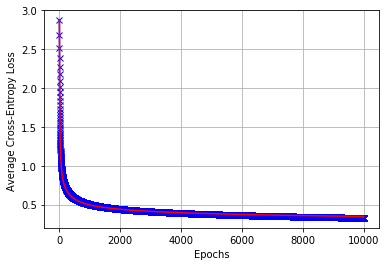

In [28]:
fig = plt.figure(1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Average Cross-Entropy Loss ')
plt.plot(range(len(train_epoch_loss_list)),train_epoch_loss_list, '-bx')
plt.plot(range(len(validation_epoch_loss_list)),validation_epoch_loss_list, '-r')

plt.show()

In [29]:
h2_values = sess.run(h2, feed_dict={x_ori:test_image_norm})

In [30]:
result_labels = np.zeros_like(h2_values,dtype=int)

In [31]:
result_labels[np.arange(len(h2_values)), h2_values.argmax(1)] = 1

In [32]:
result_labels = np.argmax(result_labels, axis=1)

In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(test_labels,result_labels, average='micro')

0.8631

In [35]:
from pandas_ml import ConfusionMatrix

In [36]:
ConfusionMatrix(test_labels,result_labels)

Predicted     0    1     2     3     4    5    6     7     8     9  __all__
Actual                                                                     
0           826    1    10    42     5    5   98     0    13     0     1000
1             5  959     5    23     2    0    4     0     2     0     1000
2            13    2   784    14   111    1   73     0     2     0     1000
3            25   11    12   883    26    1   36     0     6     0     1000
4             0    0   100    36   784    1   74     0     5     0     1000
5             0    0     0     1     0  933    0    43     2    21     1000
6           131    1   101    41    79    1  628     0    18     0     1000
7             0    0     0     0     0   33    0   932     0    35     1000
8             4    1     3     7     3    4   14     6   958     0     1000
9             1    0     0     0     0   15    0    40     0   944     1000
__all__    1005  975  1015  1047  1010  994  927  1021  1006  1000    10000